# Import libraries

In [165]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Configuration

In [277]:
window_size = 5
lstm_epochs = 50
cb_iterations = 1000

# Data Collection

In [167]:
def fetch_historical_data(symbol, interval, limit=1000):
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df

# Fetch data for different intervals
df_1m = fetch_historical_data('BTCUSDT', '1m')
df_1h = fetch_historical_data('BTCUSDT', '1h')
df_4h = fetch_historical_data('BTCUSDT', '4h')
df_1d = fetch_historical_data('BTCUSDT', '1d')

# Data Preparation

In [168]:
def prepare_data(data):
    data['returns'] = data['close'].pct_change()
    data.dropna(inplace=True)
    return data

In [169]:
# Prepare data
df_1m = prepare_data(df_1m)
df_1h = prepare_data(df_1h)
df_4h = prepare_data(df_4h)
df_1d = prepare_data(df_1d)

# Data Preprocessing

In [170]:
def split_data(df, type):
    data = df[type]
    train_data = data.iloc[:int(len(data)*0.8)]
    test_data = data.iloc[int(len(data)*0.8):]
    train_label = train_data.shift(-window_size).dropna()
    train_label.iloc[-1] = test_data.iloc[0]
    test_label = test_data.shift(-window_size).dropna()
    return np.array(train_data), np.array(train_label), np.array(test_data), np.array(test_label)

In [171]:
def extract_features_sliding_window(data, window_size):
    features = []
    for i in range(len(data) - window_size):
        features.append(data[i:i+window_size])
    return np.array(features)

In [172]:
scaler_1m_price = StandardScaler()
scaler_1h_price = StandardScaler()
scaler_4h_price = StandardScaler()
scaler_1d_price = StandardScaler()

scaler_1m_returns = MinMaxScaler()
scaler_1h_returns = MinMaxScaler()
scaler_4h_returns = MinMaxScaler()
scaler_1d_returns = MinMaxScaler()

In [173]:
df_1m['normalized_close'] = scaler_1m_price.fit_transform(df_1m['close'].values.reshape(-1, 1))
df_1h['normalized_close'] = scaler_1h_price.fit_transform(df_1h['close'].values.reshape(-1, 1))
df_4h['normalized_close'] = scaler_4h_price.fit_transform(df_4h['close'].values.reshape(-1, 1))
df_1d['normalized_close'] = scaler_1d_price.fit_transform(df_1d['close'].values.reshape(-1, 1))

df_1m['normalized_returns'] = scaler_1m_returns.fit_transform(df_1m['returns'].values.reshape(-1, 1))
df_1h['normalized_returns'] = scaler_1h_returns.fit_transform(df_1h['returns'].values.reshape(-1, 1))
df_4h['normalized_returns'] = scaler_4h_returns.fit_transform(df_4h['returns'].values.reshape(-1, 1))
df_1d['normalized_returns'] = scaler_1d_returns.fit_transform(df_1d['returns'].values.reshape(-1, 1))

In [174]:
# Split dataset
train_1m_price, train_label_1m_price, test_1m_price, test_label_1m_price = split_data(df_1m, 'normalized_close')
train_1h_price, train_label_1h_price, test_1h_price, test_label_1h_price = split_data(df_1h, 'normalized_close')
train_4h_price, train_label_4h_price, test_4h_price, test_label_4h_price = split_data(df_4h, 'normalized_close')
train_1d_price, train_label_1d_price, test_1d_price, test_label_1d_price = split_data(df_1d, 'normalized_close')

train_1m_returns, train_label_1m_returns, test_1m_returns, test_label_1m_returns = split_data(df_1m, 'normalized_returns')
train_1h_returns, train_label_1h_returns, test_1h_returns, test_label_1h_returns = split_data(df_1h, 'normalized_returns')
train_4h_returns, train_label_4h_returns, test_4h_returns, test_label_4h_returns = split_data(df_4h, 'normalized_returns')
train_1d_returns, train_label_1d_returns, test_1d_returns, test_label_1d_returns = split_data(df_1d, 'normalized_returns')

In [175]:
# Extract features
train_1m_price = extract_features_sliding_window(train_1m_price, window_size)
train_1h_price = extract_features_sliding_window(train_1h_price, window_size)
train_4h_price = extract_features_sliding_window(train_4h_price, window_size)
train_1d_price = extract_features_sliding_window(train_1d_price, window_size)

train_1m_returns = extract_features_sliding_window(train_1m_returns, window_size)
train_1h_returns = extract_features_sliding_window(train_1h_returns, window_size)
train_4h_returns = extract_features_sliding_window(train_4h_returns, window_size)
train_1d_returns = extract_features_sliding_window(train_1d_returns, window_size)

test_1m_price = extract_features_sliding_window(test_1m_price, window_size)
test_1h_price = extract_features_sliding_window(test_1h_price, window_size)
test_4h_price = extract_features_sliding_window(test_4h_price, window_size)
test_1d_price = extract_features_sliding_window(test_1d_price, window_size)

test_1m_returns = extract_features_sliding_window(test_1m_returns, window_size)
test_1h_returns = extract_features_sliding_window(test_1h_returns, window_size)
test_4h_returns = extract_features_sliding_window(test_4h_returns, window_size)
test_1d_returns = extract_features_sliding_window(test_1d_returns, window_size)

In [176]:
actual_train_label_1m_price = scaler_1m_price.inverse_transform(train_label_1m_price.reshape(-1, 1))
actual_train_label_1h_price = scaler_1h_price.inverse_transform(train_label_1h_price.reshape(-1, 1))
actual_train_label_4h_price = scaler_4h_price.inverse_transform(train_label_4h_price.reshape(-1, 1))
actual_train_label_1d_price = scaler_1d_price.inverse_transform(train_label_1d_price.reshape(-1, 1))

actual_test_label_1m_price = scaler_1m_price.inverse_transform(test_label_1m_price.reshape(-1, 1))
actual_test_label_1h_price = scaler_1h_price.inverse_transform(test_label_1h_price.reshape(-1, 1))
actual_test_label_4h_price = scaler_4h_price.inverse_transform(test_label_4h_price.reshape(-1, 1))
actual_test_label_1d_price = scaler_1d_price.inverse_transform(test_label_1d_price.reshape(-1, 1))

actual_train_label_1m_returns = scaler_1m_returns.inverse_transform(train_label_1m_returns.reshape(-1, 1))
actual_train_label_1h_returns = scaler_1h_returns.inverse_transform(train_label_1h_returns.reshape(-1, 1))
actual_train_label_4h_returns = scaler_4h_returns.inverse_transform(train_label_4h_returns.reshape(-1, 1))
actual_train_label_1d_returns = scaler_1d_returns.inverse_transform(train_label_1d_returns.reshape(-1, 1))

actual_test_label_1m_returns = scaler_1m_returns.inverse_transform(test_label_1m_returns.reshape(-1, 1))
actual_test_label_1h_returns = scaler_1h_returns.inverse_transform(test_label_1h_returns.reshape(-1, 1))
actual_test_label_4h_returns = scaler_4h_returns.inverse_transform(test_label_4h_returns.reshape(-1, 1))
actual_test_label_1d_returns = scaler_1d_returns.inverse_transform(test_label_1d_returns.reshape(-1, 1))


# Useful Function

In [177]:
def plot_forecast_result(train_pred, test_pred, actual, title, type=None):
  model = ' '.join(title.split()[:-2])
  plt.xlabel('Date')
  if type == 'train':
    plt.title('[Training] ' + title)
    actual = actual.iloc[window_size:len(train_pred)+window_size]
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, train_pred, label=f'{model} (Train)')
  elif type == 'test':
    plt.title('[Testing] ' + title)
    actual = actual.iloc[len(train_pred)+2*window_size-1:-1]
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, test_pred, color='red', label=f'{model} (Test)')
  else:
    plt.title(title)
    plt.plot(actual, label='Actual')
    plt.plot(actual.iloc[window_size:len(train_pred)+window_size].index, train_pred, label=f'{model} (Train)')
    plt.plot(actual.iloc[len(train_pred)+2*window_size-1:-1].index, test_pred, color='red', label=f'{model} (Test)')
  plt.legend()
  plt.show()

# Modeling

## Linear Regression

In [178]:
from sklearn.linear_model import LinearRegression

In [179]:
lr_model_1m_price = LinearRegression().fit(train_1m_price, train_label_1m_price)
lr_model_1h_price = LinearRegression().fit(train_1h_price, train_label_1h_price)
lr_model_4h_price = LinearRegression().fit(train_4h_price, train_label_4h_price)
lr_model_1d_price = LinearRegression().fit(train_1d_price, train_label_1d_price)

lr_model_1m_returns = LinearRegression().fit(train_1m_returns, train_label_1m_returns)
lr_model_1h_returns = LinearRegression().fit(train_1h_returns, train_label_1h_returns)
lr_model_4h_returns = LinearRegression().fit(train_4h_returns, train_label_4h_returns)
lr_model_1d_returns = LinearRegression().fit(train_1d_returns, train_label_1d_returns)

In [180]:
lr_preds_train_1m_price = scaler_1m_price.inverse_transform(lr_model_1m_price.predict(train_1m_price).reshape(-1,1)).squeeze()
lr_preds_train_1h_price = scaler_1h_price.inverse_transform(lr_model_1h_price.predict(train_1h_price).reshape(-1,1)).squeeze()
lr_preds_train_4h_price = scaler_4h_price.inverse_transform(lr_model_4h_price.predict(train_4h_price).reshape(-1,1)).squeeze()
lr_preds_train_1d_price = scaler_1d_price.inverse_transform(lr_model_1d_price.predict(train_1d_price).reshape(-1,1)).squeeze()

lr_preds_test_1m_price = scaler_1m_price.inverse_transform(lr_model_1m_price.predict(test_1m_price).reshape(-1,1)).squeeze()
lr_preds_test_1h_price = scaler_1h_price.inverse_transform(lr_model_1h_price.predict(test_1h_price).reshape(-1,1)).squeeze()
lr_preds_test_4h_price = scaler_4h_price.inverse_transform(lr_model_4h_price.predict(test_4h_price).reshape(-1,1)).squeeze()
lr_preds_test_1d_price = scaler_1d_price.inverse_transform(lr_model_1d_price.predict(test_1d_price).reshape(-1,1)).squeeze()

lr_preds_train_1m_returns = scaler_1m_returns.inverse_transform(lr_model_1m_returns.predict(train_1m_returns).reshape(-1,1)).squeeze()
lr_preds_train_1h_returns = scaler_1h_returns.inverse_transform(lr_model_1h_returns.predict(train_1h_returns).reshape(-1,1)).squeeze()
lr_preds_train_4h_returns = scaler_4h_returns.inverse_transform(lr_model_4h_returns.predict(train_4h_returns).reshape(-1,1)).squeeze()
lr_preds_train_1d_returns = scaler_1d_returns.inverse_transform(lr_model_1d_returns.predict(train_1d_returns).reshape(-1,1)).squeeze()

lr_preds_test_1m_returns = scaler_1m_returns.inverse_transform(lr_model_1m_returns.predict(test_1m_returns).reshape(-1,1)).squeeze()
lr_preds_test_1h_returns = scaler_1h_returns.inverse_transform(lr_model_1h_returns.predict(test_1h_returns).reshape(-1,1)).squeeze()
lr_preds_test_4h_returns = scaler_4h_returns.inverse_transform(lr_model_4h_returns.predict(test_4h_returns).reshape(-1,1)).squeeze()
lr_preds_test_1d_returns = scaler_1d_returns.inverse_transform(lr_model_1d_returns.predict(test_1d_returns).reshape(-1,1)).squeeze()

In [181]:
print('***Linear Regression Training Evaluation (Price)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(actual_train_label_1m_price, lr_preds_train_1m_price):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1m_price, lr_preds_train_1m_price):.6f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(actual_train_label_1h_price, lr_preds_train_1h_price):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1h_price, lr_preds_train_1h_price):.6f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(actual_train_label_4h_price, lr_preds_train_4h_price):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_4h_price, lr_preds_train_4h_price):.6f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(actual_train_label_1d_price, lr_preds_train_1d_price):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1d_price, lr_preds_train_1d_price):.6f}')

***Linear Regression Training Evaluation (Price)***
---1 Minute---
R²: 0.986842
MSE: 1225.484764
---1 Hour---
R²: 0.992005
MSE: 89576.541436
---4 Hours---
R²: 0.984880
MSE: 543567.093174
---1 Days---
R²: 0.991900
MSE: 921254.397682


In [182]:
print('***Linear Regression Testing Evaluation (Price)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(actual_test_label_1m_price, lr_preds_test_1m_price):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1m_price, lr_preds_test_1m_price):.6f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(actual_test_label_1h_price, lr_preds_test_1h_price):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1h_price, lr_preds_test_1h_price):.6f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(actual_test_label_4h_price, lr_preds_test_4h_price):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_4h_price, lr_preds_test_4h_price):.6f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(actual_test_label_1d_price, lr_preds_test_1d_price):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1d_price, lr_preds_test_1d_price):.6f}')

***Linear Regression Testing Evaluation (Price)***
---1 Minute---
R²: 0.985569
MSE: 1654.173490
---1 Hour---
R²: 0.946023
MSE: 85625.022315
---4 Hours---
R²: 0.969128
MSE: 373648.980367
---1 Days---
R²: 0.963559
MSE: 3128005.162717


In [183]:
print('***Linear Regression Training Evaluation (Returns)***')
print('---1m returns---')
print(f'R\u00b2: {r2_score(actual_train_label_1m_returns, lr_preds_train_1m_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1m_returns, lr_preds_train_1m_returns):.6f}')
print('---1h returns---')
print(f'R\u00b2: {r2_score(actual_train_label_1h_returns, lr_preds_train_1h_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1h_returns, lr_preds_train_1h_returns):.6f}')
print('---4h returns---')
print(f'R\u00b2: {r2_score(actual_train_label_4h_returns, lr_preds_train_4h_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_4h_returns, lr_preds_train_4h_returns):.6f}')
print('---1d returns---')
print(f'R\u00b2: {r2_score(actual_train_label_1d_returns, lr_preds_train_1d_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1d_returns, lr_preds_train_1d_returns):.6f}')

***Linear Regression Training Evaluation (Returns)***
---1m returns---
R²: 0.013936
MSE: 0.000000
---1h returns---
R²: 0.004913
MSE: 0.000025
---4h returns---
R²: 0.003135
MSE: 0.000132
---1d returns---
R²: 0.001047
MSE: 0.000846


In [184]:
print('***Linear Regression Testing Evaluation (Returns)***')
print('---1m returns---')
print(f'R\u00b2: {r2_score(actual_test_label_1m_returns, lr_preds_test_1m_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1m_returns, lr_preds_test_1m_returns):.6f}')
print('---1h returns---')
print(f'R\u00b2: {r2_score(actual_test_label_1h_returns, lr_preds_test_1h_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1h_returns, lr_preds_test_1h_returns):.6f}')
print('---4h returns---')
print(f'R\u00b2: {r2_score(actual_test_label_4h_returns, lr_preds_test_4h_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_4h_returns, lr_preds_test_4h_returns):.6f}')
print('---1d returns---')
print(f'R\u00b2: {r2_score(actual_test_label_1d_returns, lr_preds_test_1d_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1d_returns, lr_preds_test_1d_returns):.6f}')

***Linear Regression Testing Evaluation (Returns)***
---1m returns---
R²: -0.055723
MSE: 0.000000
---1h returns---
R²: -0.006918
MSE: 0.000019
---4h returns---
R²: -0.019618
MSE: 0.000101
---1d returns---
R²: -0.002004
MSE: 0.000790


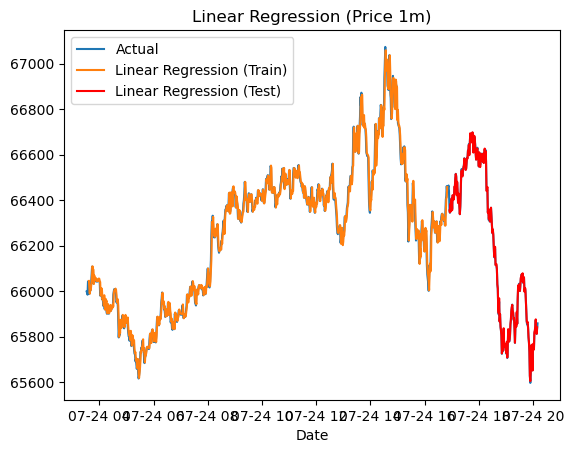

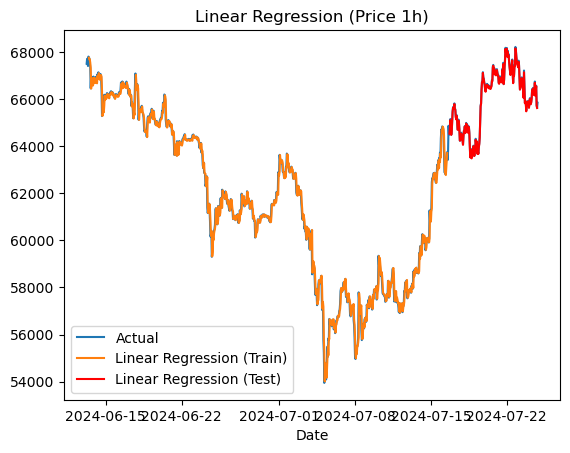

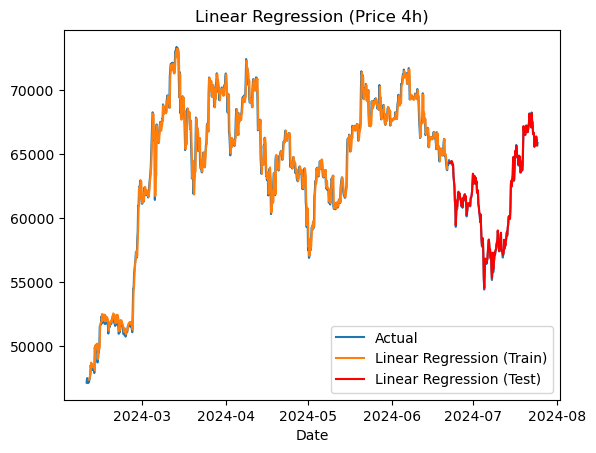

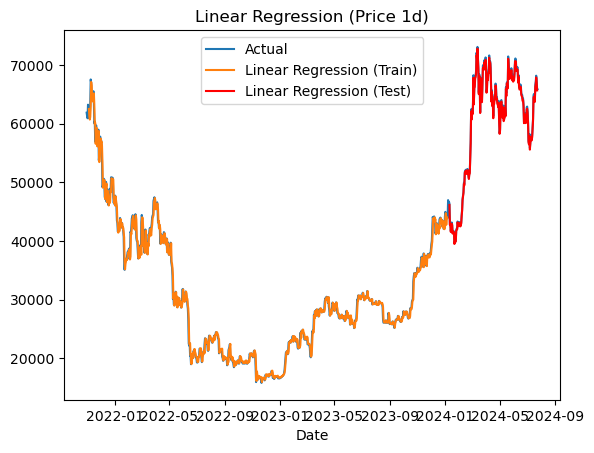

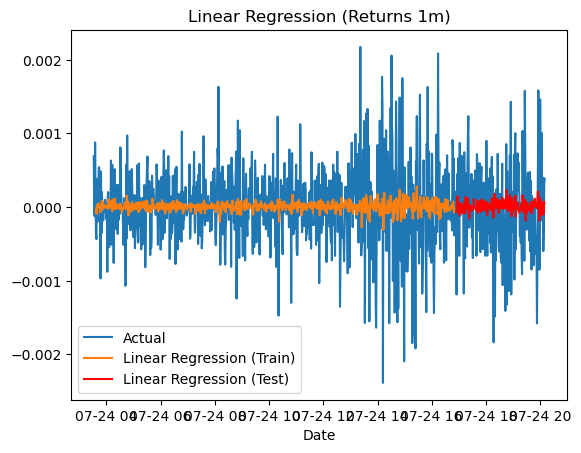

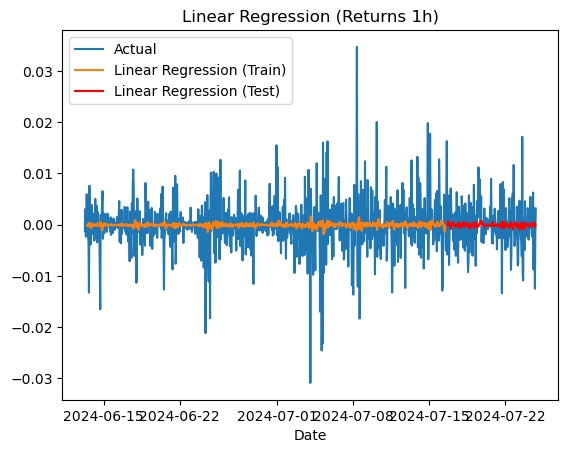

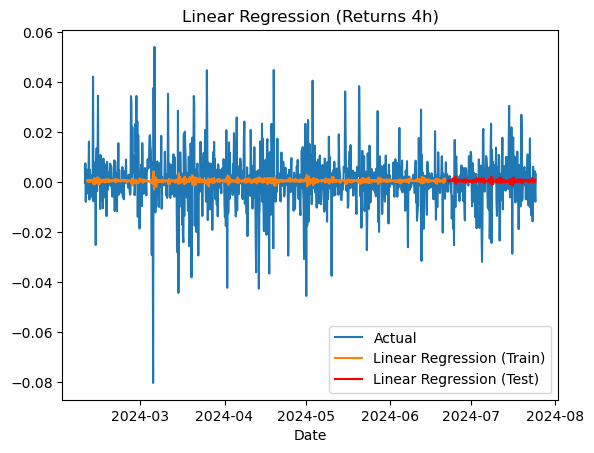

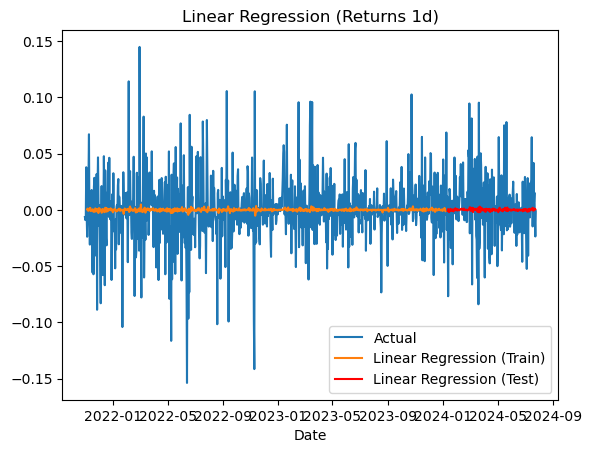

In [185]:
plot_forecast_result(lr_preds_train_1m_price, lr_preds_test_1m_price, df_1m['close'], 'Linear Regression (Price 1m)')
plot_forecast_result(lr_preds_train_1h_price, lr_preds_test_1h_price, df_1h['close'], 'Linear Regression (Price 1h)')
plot_forecast_result(lr_preds_train_4h_price, lr_preds_test_4h_price, df_4h['close'], 'Linear Regression (Price 4h)')
plot_forecast_result(lr_preds_train_1d_price, lr_preds_test_1d_price, df_1d['close'], 'Linear Regression (Price 1d)')

plot_forecast_result(lr_preds_train_1m_returns, lr_preds_test_1m_returns, df_1m['returns'], 'Linear Regression (Returns 1m)')
plot_forecast_result(lr_preds_train_1h_returns, lr_preds_test_1h_returns, df_1h['returns'], 'Linear Regression (Returns 1h)')
plot_forecast_result(lr_preds_train_4h_returns, lr_preds_test_4h_returns, df_4h['returns'], 'Linear Regression (Returns 4h)')
plot_forecast_result(lr_preds_train_1d_returns, lr_preds_test_1d_returns, df_1d['returns'], 'Linear Regression (Returns 1d)')

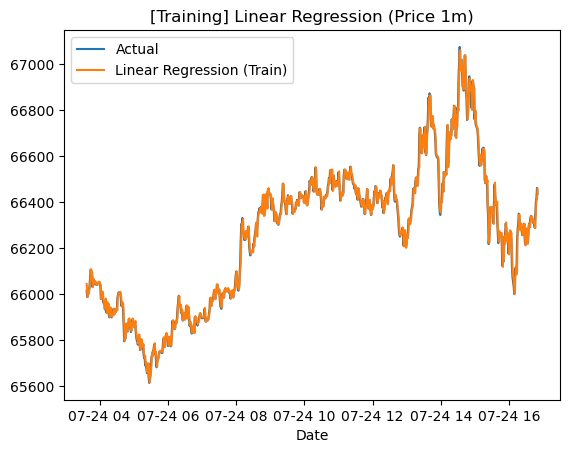

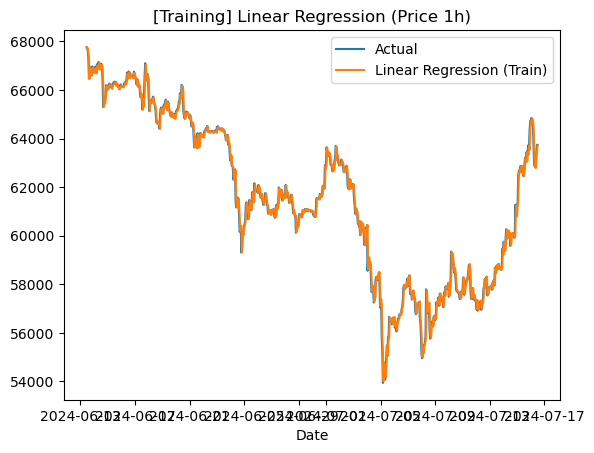

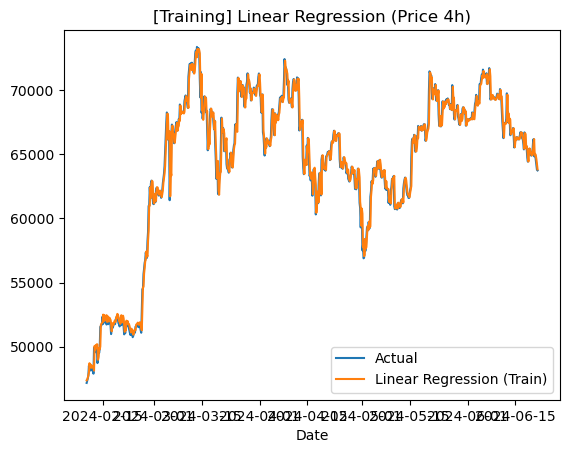

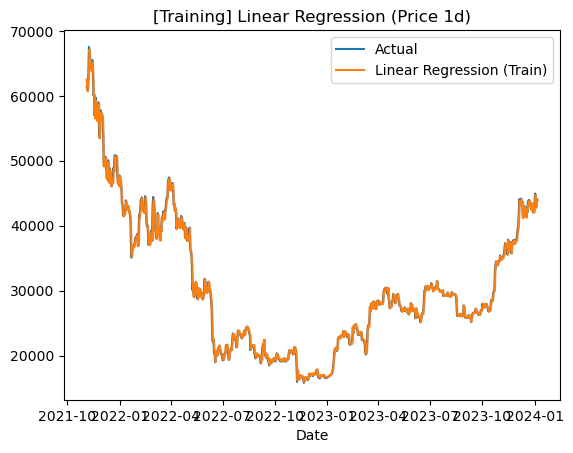

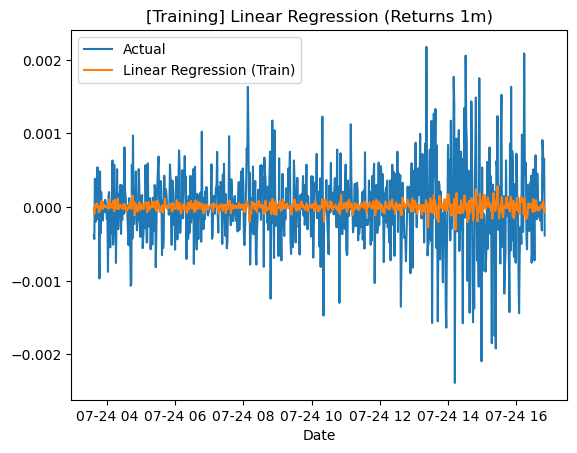

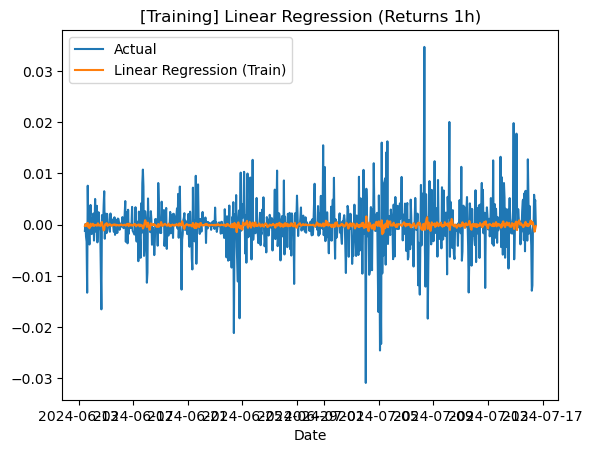

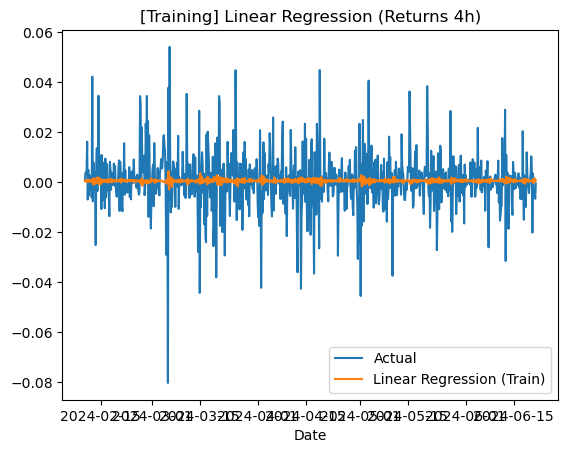

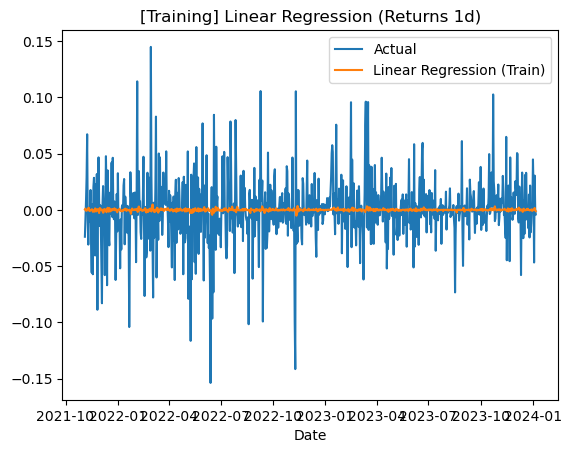

In [186]:
plot_forecast_result(lr_preds_train_1m_price, lr_preds_test_1m_price, df_1m['close'], 'Linear Regression (Price 1m)', 'train')
plot_forecast_result(lr_preds_train_1h_price, lr_preds_test_1h_price, df_1h['close'], 'Linear Regression (Price 1h)', 'train')
plot_forecast_result(lr_preds_train_4h_price, lr_preds_test_4h_price, df_4h['close'], 'Linear Regression (Price 4h)', 'train')
plot_forecast_result(lr_preds_train_1d_price, lr_preds_test_1d_price, df_1d['close'], 'Linear Regression (Price 1d)', 'train')

plot_forecast_result(lr_preds_train_1m_returns, lr_preds_test_1m_returns, df_1m['returns'], 'Linear Regression (Returns 1m)', 'train')
plot_forecast_result(lr_preds_train_1h_returns, lr_preds_test_1h_returns, df_1h['returns'], 'Linear Regression (Returns 1h)', 'train')
plot_forecast_result(lr_preds_train_4h_returns, lr_preds_test_4h_returns, df_4h['returns'], 'Linear Regression (Returns 4h)', 'train')
plot_forecast_result(lr_preds_train_1d_returns, lr_preds_test_1d_returns, df_1d['returns'], 'Linear Regression (Returns 1d)', 'train')

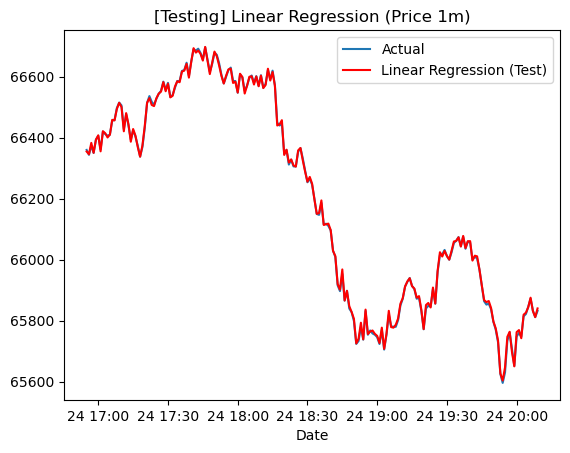

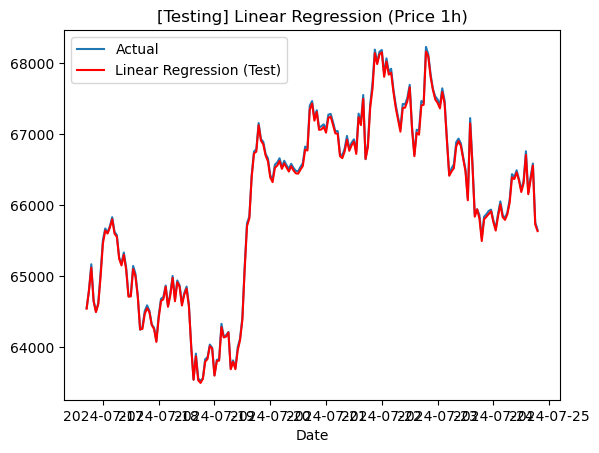

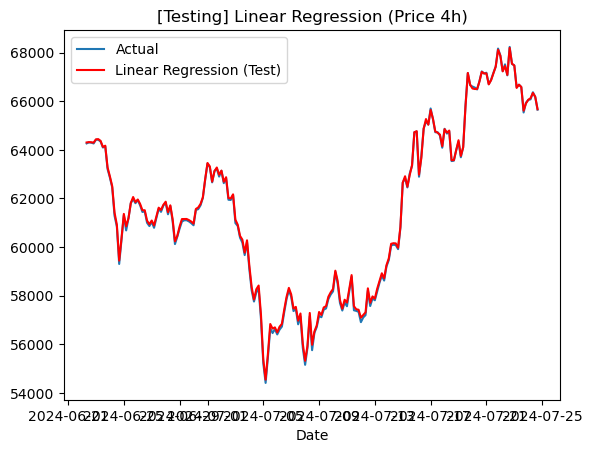

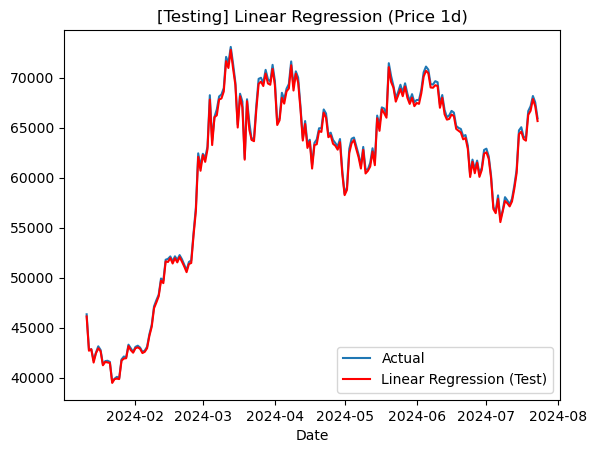

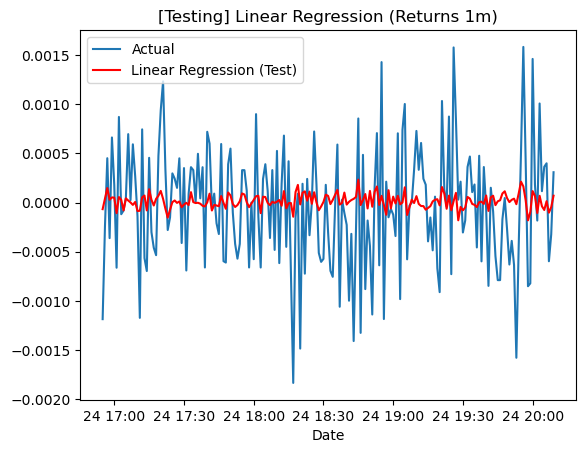

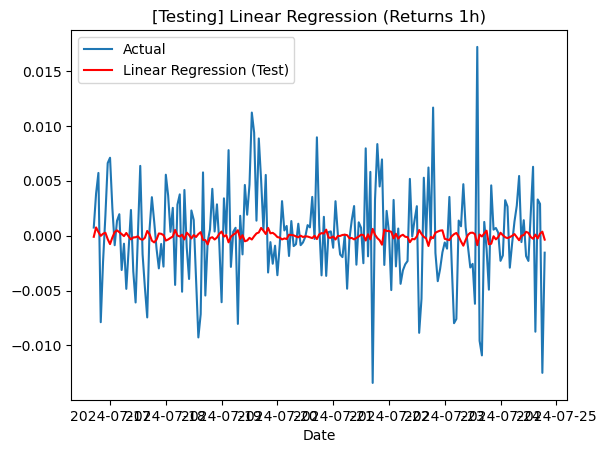

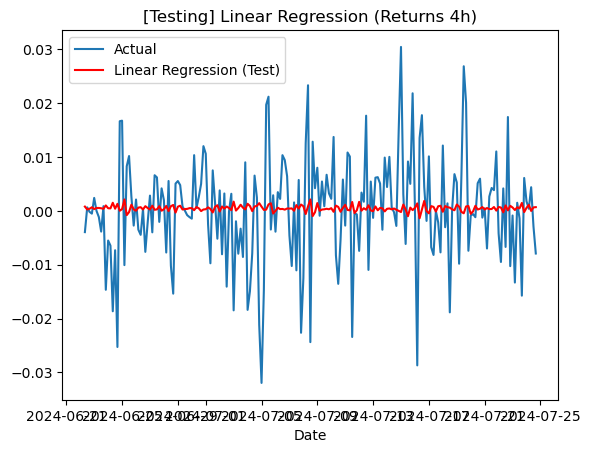

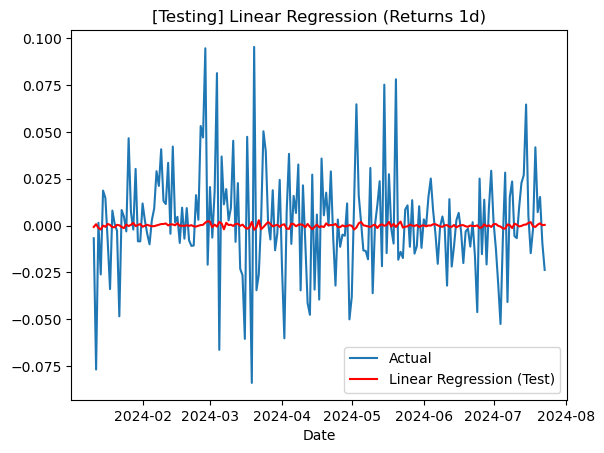

In [187]:
plot_forecast_result(lr_preds_train_1m_price, lr_preds_test_1m_price, df_1m['close'], 'Linear Regression (Price 1m)', 'test')
plot_forecast_result(lr_preds_train_1h_price, lr_preds_test_1h_price, df_1h['close'], 'Linear Regression (Price 1h)', 'test')
plot_forecast_result(lr_preds_train_4h_price, lr_preds_test_4h_price, df_4h['close'], 'Linear Regression (Price 4h)', 'test')
plot_forecast_result(lr_preds_train_1d_price, lr_preds_test_1d_price, df_1d['close'], 'Linear Regression (Price 1d)', 'test')

plot_forecast_result(lr_preds_train_1m_returns, lr_preds_test_1m_returns, df_1m['returns'], 'Linear Regression (Returns 1m)', 'test')
plot_forecast_result(lr_preds_train_1h_returns, lr_preds_test_1h_returns, df_1h['returns'], 'Linear Regression (Returns 1h)', 'test')
plot_forecast_result(lr_preds_train_4h_returns, lr_preds_test_4h_returns, df_4h['returns'], 'Linear Regression (Returns 4h)', 'test')
plot_forecast_result(lr_preds_train_1d_returns, lr_preds_test_1d_returns, df_1d['returns'], 'Linear Regression (Returns 1d)', 'test')

## CatBoost

In [249]:
from catboost import Pool, CatBoostRegressor

In [250]:
cb_train_pool_1m_price, cb_test_pool_1m_price = Pool(train_1m_price, train_label_1m_price), Pool(test_1m_price)
cb_train_pool_1h_price, cb_test_pool_1h_price = Pool(train_1h_price, train_label_1h_price), Pool(test_1h_price)
cb_train_pool_4h_price, cb_test_pool_4h_price = Pool(train_4h_price, train_label_4h_price), Pool(test_4h_price)
cb_train_pool_1d_price, cb_test_pool_1d_price = Pool(train_1d_price, train_label_1d_price), Pool(test_1d_price)

cb_train_pool_1m_returns, cb_test_pool_1m_returns = Pool(train_1m_returns, train_label_1m_returns), Pool(test_1m_returns)
cb_train_pool_1h_returns, cb_test_pool_1h_returns = Pool(train_1h_returns, train_label_1h_returns), Pool(test_1h_returns)
cb_train_pool_4h_returns, cb_test_pool_4h_returns = Pool(train_4h_returns, train_label_4h_returns), Pool(test_4h_returns)
cb_train_pool_1d_returns, cb_test_pool_1d_returns = Pool(train_1d_returns, train_label_1d_returns), Pool(test_1d_returns)

In [251]:
cb_model_1m_price = CatBoostRegressor(iterations=cb_iterations)
cb_model_1m_price.fit(cb_train_pool_1m_price)

cb_model_1h_price = CatBoostRegressor(iterations=cb_iterations)
cb_model_1h_price.fit(cb_train_pool_1h_price)

cb_model_4h_price = CatBoostRegressor(iterations=cb_iterations)
cb_model_4h_price.fit(cb_train_pool_4h_price)

cb_model_1d_price = CatBoostRegressor(iterations=cb_iterations)
cb_model_1d_price.fit(cb_train_pool_1d_price)

cb_model_1m_returns = CatBoostRegressor(iterations=cb_iterations)
cb_model_1m_returns.fit(cb_train_pool_1m_returns)

cb_model_1h_returns = CatBoostRegressor(iterations=cb_iterations)
cb_model_1h_returns.fit(cb_train_pool_1h_returns)

cb_model_4h_returns = CatBoostRegressor(iterations=cb_iterations)
cb_model_4h_returns.fit(cb_train_pool_4h_returns)

cb_model_1d_returns = CatBoostRegressor(iterations=cb_iterations)
cb_model_1d_returns.fit(cb_train_pool_1d_returns)

Learning rate set to 0.039478
0:	learn: 0.9423041	total: 1.57ms	remaining: 1.57s
1:	learn: 0.9090341	total: 2.75ms	remaining: 1.37s
2:	learn: 0.8767846	total: 3.84ms	remaining: 1.27s
3:	learn: 0.8460490	total: 5.05ms	remaining: 1.26s
4:	learn: 0.8167987	total: 6.27ms	remaining: 1.25s
5:	learn: 0.7887318	total: 7.35ms	remaining: 1.22s
6:	learn: 0.7619738	total: 8.57ms	remaining: 1.22s
7:	learn: 0.7354578	total: 9.97ms	remaining: 1.24s
8:	learn: 0.7109904	total: 11.3ms	remaining: 1.24s
9:	learn: 0.6865696	total: 15.5ms	remaining: 1.53s
10:	learn: 0.6635368	total: 16.9ms	remaining: 1.52s
11:	learn: 0.6417444	total: 18.2ms	remaining: 1.5s
12:	learn: 0.6198602	total: 19.9ms	remaining: 1.51s
13:	learn: 0.5990355	total: 22ms	remaining: 1.55s
14:	learn: 0.5791948	total: 25.5ms	remaining: 1.67s
15:	learn: 0.5598762	total: 30.8ms	remaining: 1.89s
16:	learn: 0.5418368	total: 31.9ms	remaining: 1.84s
17:	learn: 0.5246935	total: 32.8ms	remaining: 1.79s
18:	learn: 0.5078448	total: 33.9ms	remaining: 1

In [252]:
cb_preds_train_1m_price = scaler_1m_price.inverse_transform(cb_model_1m_price.predict(cb_train_pool_1m_price).reshape(-1, 1))
cb_preds_train_1h_price = scaler_1h_price.inverse_transform(cb_model_1h_price.predict(cb_train_pool_1h_price).reshape(-1, 1))
cb_preds_train_4h_price = scaler_4h_price.inverse_transform(cb_model_4h_price.predict(cb_train_pool_4h_price).reshape(-1, 1))
cb_preds_train_1d_price = scaler_1d_price.inverse_transform(cb_model_1d_price.predict(cb_train_pool_1d_price).reshape(-1, 1))

cb_preds_test_1m_price = scaler_1m_price.inverse_transform(cb_model_1m_price.predict(cb_test_pool_1m_price).reshape(-1, 1))
cb_preds_test_1h_price = scaler_1h_price.inverse_transform(cb_model_1h_price.predict(cb_test_pool_1h_price).reshape(-1, 1))
cb_preds_test_4h_price = scaler_4h_price.inverse_transform(cb_model_4h_price.predict(cb_test_pool_4h_price).reshape(-1, 1))
cb_preds_test_1d_price = scaler_1d_price.inverse_transform(cb_model_1d_price.predict(cb_test_pool_1d_price).reshape(-1, 1))

cb_preds_train_1m_returns = scaler_1m_returns.inverse_transform(cb_model_1m_returns.predict(cb_train_pool_1m_returns).reshape(-1, 1))
cb_preds_train_1h_returns = scaler_1h_returns.inverse_transform(cb_model_1h_returns.predict(cb_train_pool_1h_returns).reshape(-1, 1))
cb_preds_train_4h_returns = scaler_4h_returns.inverse_transform(cb_model_4h_returns.predict(cb_train_pool_4h_returns).reshape(-1, 1))
cb_preds_train_1d_returns = scaler_1d_returns.inverse_transform(cb_model_1d_returns.predict(cb_train_pool_1d_returns).reshape(-1, 1))

cb_preds_test_1m_returns = scaler_1m_returns.inverse_transform(cb_model_1m_returns.predict(cb_test_pool_1m_returns).reshape(-1, 1))
cb_preds_test_1h_returns = scaler_1h_returns.inverse_transform(cb_model_1h_returns.predict(cb_test_pool_1h_returns).reshape(-1, 1))
cb_preds_test_4h_returns = scaler_4h_returns.inverse_transform(cb_model_4h_returns.predict(cb_test_pool_4h_returns).reshape(-1, 1))
cb_preds_test_1d_returns = scaler_1d_returns.inverse_transform(cb_model_1d_returns.predict(cb_test_pool_1d_returns).reshape(-1, 1))


In [253]:
print('***CatBoost Training Evaluation (Price)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(actual_train_label_1m_price, cb_preds_train_1m_price):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1m_price, cb_preds_train_1m_price):.6f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(actual_train_label_1h_price, cb_preds_train_1h_price):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1h_price, cb_preds_train_1h_price):.6f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(actual_train_label_4h_price, cb_preds_train_4h_price):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_4h_price, cb_preds_train_4h_price):.6f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(actual_train_label_1d_price, cb_preds_train_1d_price):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1d_price, cb_preds_train_1d_price):.6f}')

***CatBoost Training Evaluation (Price)***
---1 Minute---
R²: 0.995670
MSE: 403.253327
---1 Hour---
R²: 0.997178
MSE: 31618.231987
---4 Hours---
R²: 0.995640
MSE: 156736.334865
---1 Days---
R²: 0.997516
MSE: 282527.073222


In [254]:
print('***CatBoost Testing Evaluation*** (Price)')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(actual_test_label_1m_price, cb_preds_test_1m_price):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1m_price, cb_preds_test_1m_price):.6f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(actual_test_label_1h_price, cb_preds_test_1h_price):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1h_price, cb_preds_test_1h_price):.6f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(actual_test_label_4h_price, cb_preds_test_4h_price):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_4h_price, cb_preds_test_4h_price):.6f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(actual_test_label_1d_price, cb_preds_test_1d_price):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1d_price, cb_preds_test_1d_price):.6f}')

***CatBoost Testing Evaluation*** (Price)
---1 Minute---
R²: 0.981916
MSE: 2072.918454
---1 Hour---
R²: 0.909386
MSE: 143741.978902
---4 Hours---
R²: 0.954919
MSE: 545621.021285
---1 Days---
R²: 0.862122
MSE: 11835058.938326


In [255]:
print('***CatBoost Training Evaluation (Returns)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(actual_train_label_1m_returns, cb_preds_train_1m_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1m_returns, cb_preds_train_1m_returns):.6f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(actual_train_label_1h_returns, cb_preds_train_1h_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1h_returns, cb_preds_train_1h_returns):.6f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(actual_train_label_4h_returns, cb_preds_train_4h_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_4h_returns, cb_preds_train_4h_returns):.6f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(actual_train_label_1d_returns, cb_preds_train_1d_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1d_returns, cb_preds_train_1d_returns):.6f}')

***CatBoost Training Evaluation (Returns)***
---1 Minute---
R²: 0.816852
MSE: 0.000000
---1 Hour---
R²: 0.836923
MSE: 0.000004
---4 Hours---
R²: 0.841472
MSE: 0.000021
---1 Days---
R²: 0.839988
MSE: 0.000135


In [256]:
print('***CatBoost Testing Evaluation (Returns)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(actual_test_label_1m_returns, cb_preds_test_1m_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1m_returns, cb_preds_test_1m_returns):.6f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(actual_test_label_1h_returns, cb_preds_test_1h_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1h_returns, cb_preds_test_1h_returns):.6f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(actual_test_label_4h_returns, cb_preds_test_4h_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_4h_returns, cb_preds_test_4h_returns):.6f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(actual_test_label_1d_returns, cb_preds_test_1d_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1d_returns, cb_preds_test_1d_returns):.6f}')

***CatBoost Testing Evaluation (Returns)***
---1 Minute---
R²: -0.109612
MSE: 0.000000
---1 Hour---
R²: -0.108713
MSE: 0.000021
---4 Hours---
R²: -0.232786
MSE: 0.000122
---1 Days---
R²: -0.138280
MSE: 0.000898


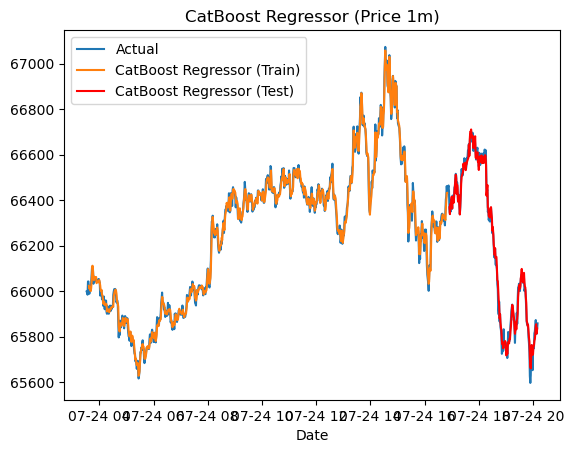

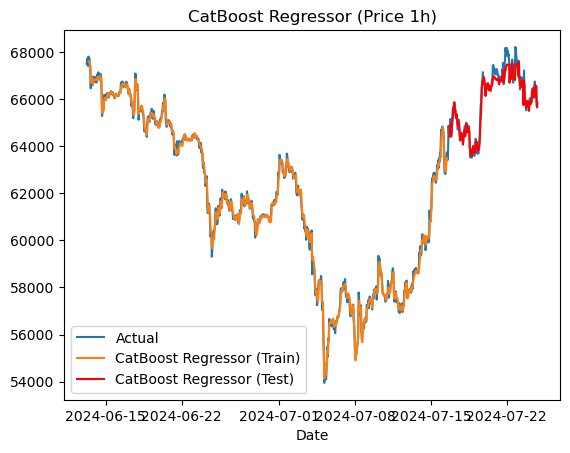

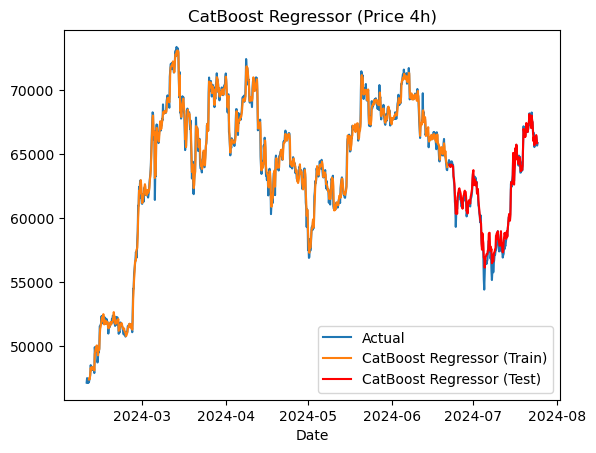

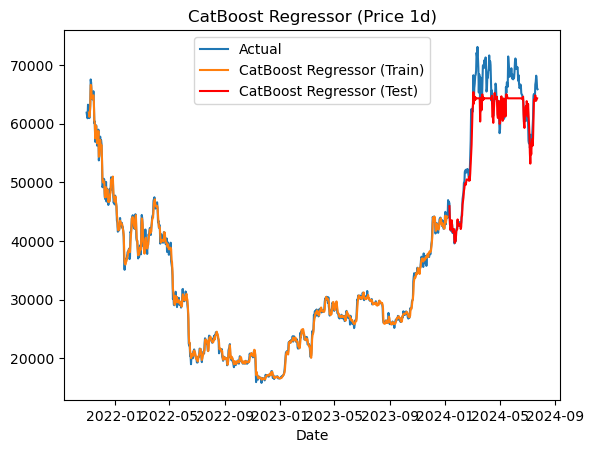

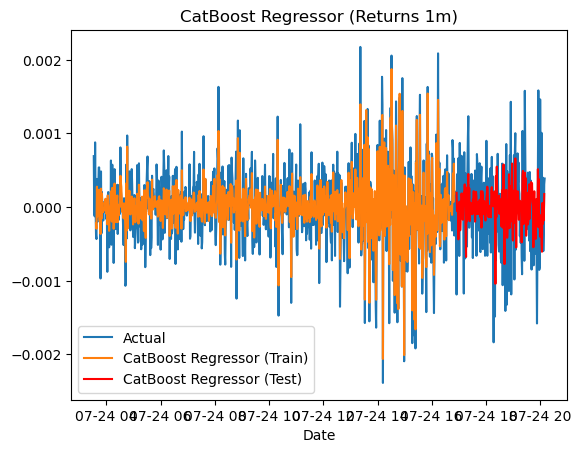

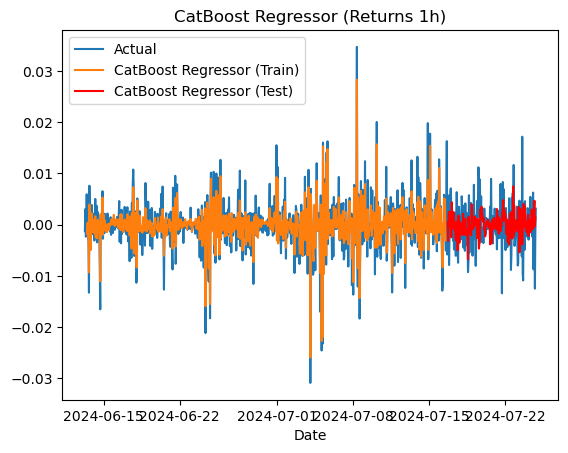

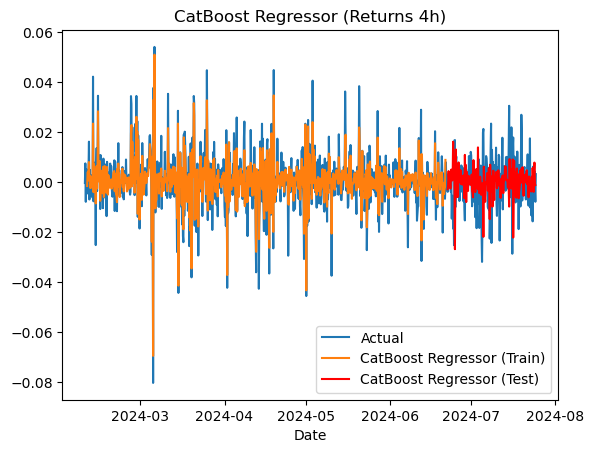

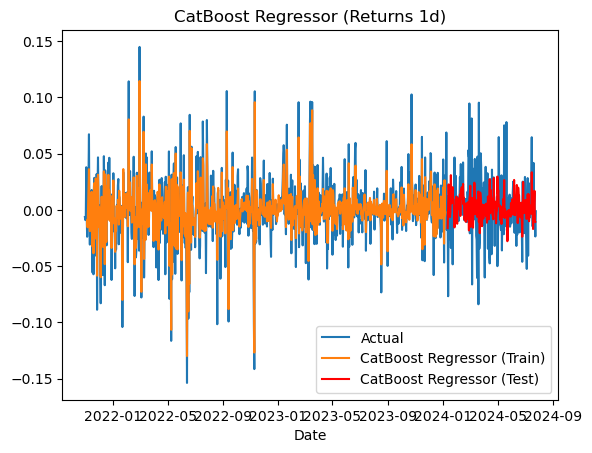

In [257]:
plot_forecast_result(cb_preds_train_1m_price, cb_preds_test_1m_price, df_1m['close'], 'CatBoost Regressor (Price 1m)')
plot_forecast_result(cb_preds_train_1h_price, cb_preds_test_1h_price, df_1h['close'], 'CatBoost Regressor (Price 1h)')
plot_forecast_result(cb_preds_train_4h_price, cb_preds_test_4h_price, df_4h['close'], 'CatBoost Regressor (Price 4h)')
plot_forecast_result(cb_preds_train_1d_price, cb_preds_test_1d_price, df_1d['close'], 'CatBoost Regressor (Price 1d)')

plot_forecast_result(cb_preds_train_1m_returns, cb_preds_test_1m_returns, df_1m['returns'], 'CatBoost Regressor (Returns 1m)')
plot_forecast_result(cb_preds_train_1h_returns, cb_preds_test_1h_returns, df_1h['returns'], 'CatBoost Regressor (Returns 1h)')
plot_forecast_result(cb_preds_train_4h_returns, cb_preds_test_4h_returns, df_4h['returns'], 'CatBoost Regressor (Returns 4h)')
plot_forecast_result(cb_preds_train_1d_returns, cb_preds_test_1d_returns, df_1d['returns'], 'CatBoost Regressor (Returns 1d)')

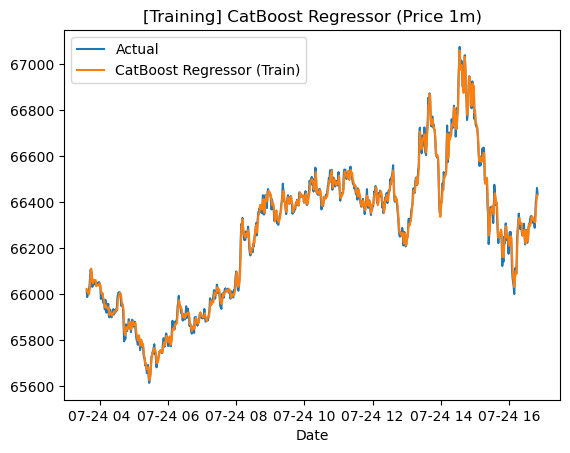

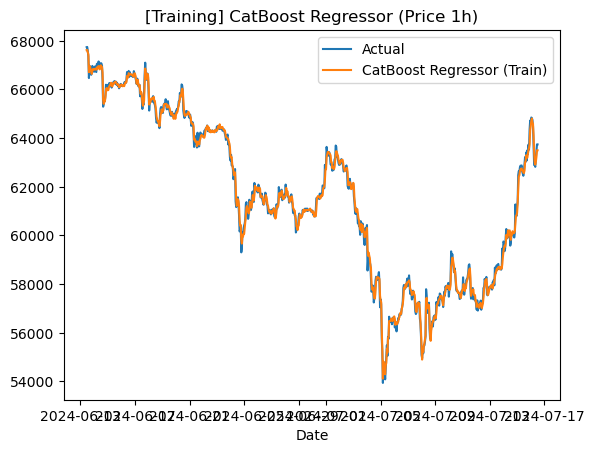

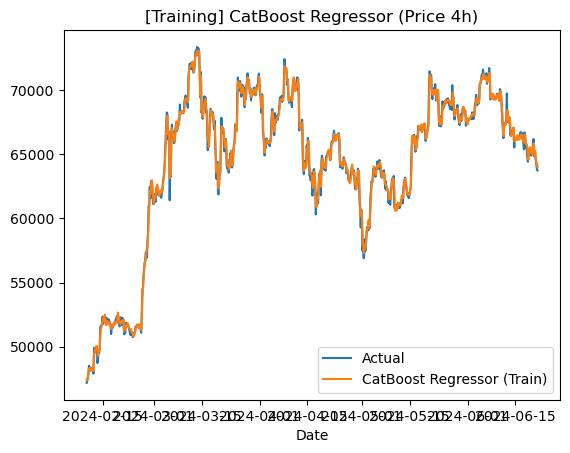

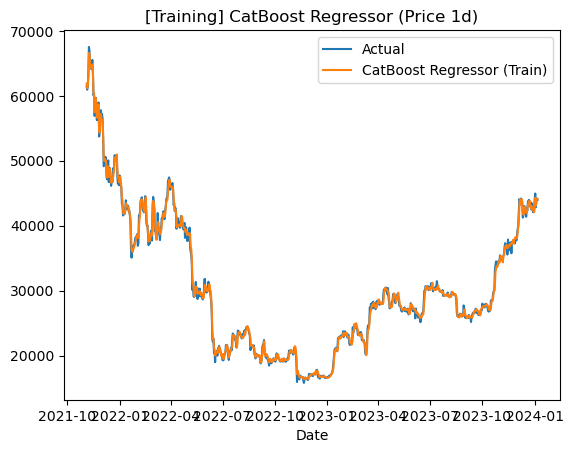

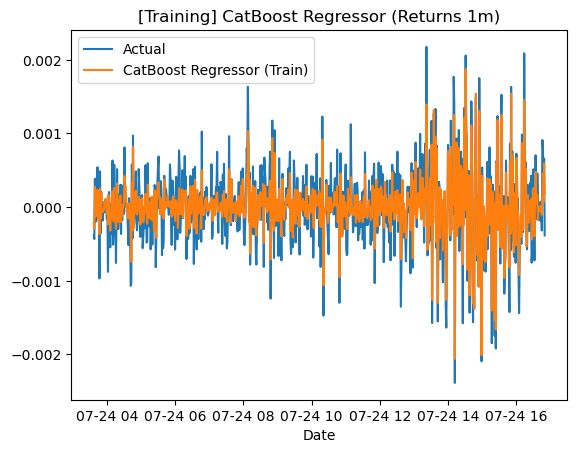

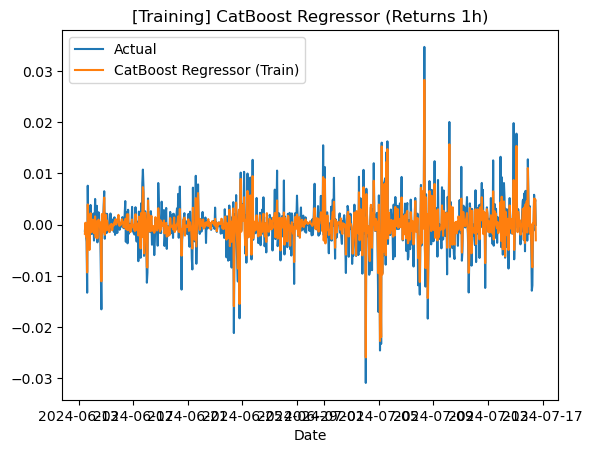

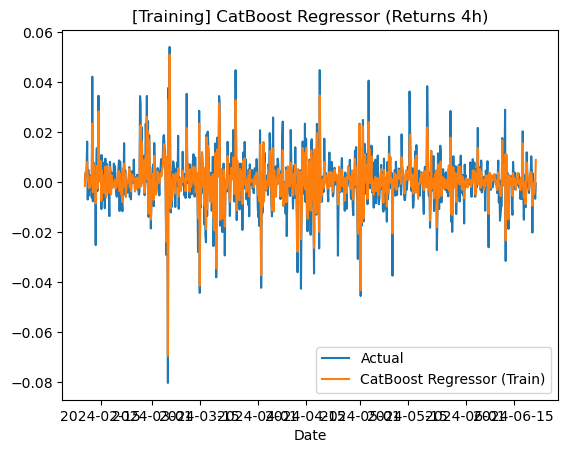

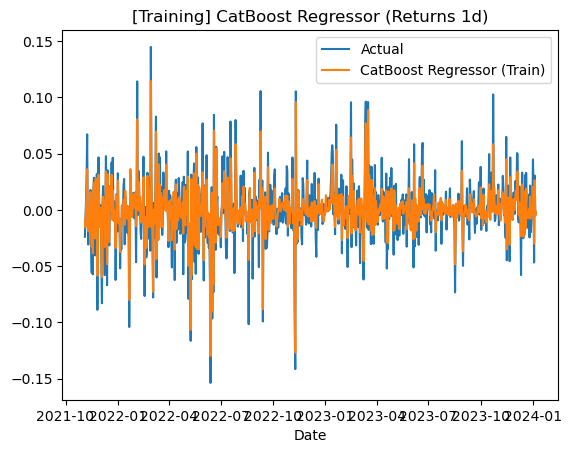

In [258]:
plot_forecast_result(cb_preds_train_1m_price, cb_preds_test_1m_price, df_1m['close'], 'CatBoost Regressor (Price 1m)', 'train')
plot_forecast_result(cb_preds_train_1h_price, cb_preds_test_1h_price, df_1h['close'], 'CatBoost Regressor (Price 1h)', 'train')
plot_forecast_result(cb_preds_train_4h_price, cb_preds_test_4h_price, df_4h['close'], 'CatBoost Regressor (Price 4h)', 'train')
plot_forecast_result(cb_preds_train_1d_price, cb_preds_test_1d_price, df_1d['close'], 'CatBoost Regressor (Price 1d)', 'train')

plot_forecast_result(cb_preds_train_1m_returns, cb_preds_test_1m_returns, df_1m['returns'], 'CatBoost Regressor (Returns 1m)', 'train')
plot_forecast_result(cb_preds_train_1h_returns, cb_preds_test_1h_returns, df_1h['returns'], 'CatBoost Regressor (Returns 1h)', 'train')
plot_forecast_result(cb_preds_train_4h_returns, cb_preds_test_4h_returns, df_4h['returns'], 'CatBoost Regressor (Returns 4h)', 'train')
plot_forecast_result(cb_preds_train_1d_returns, cb_preds_test_1d_returns, df_1d['returns'], 'CatBoost Regressor (Returns 1d)', 'train')

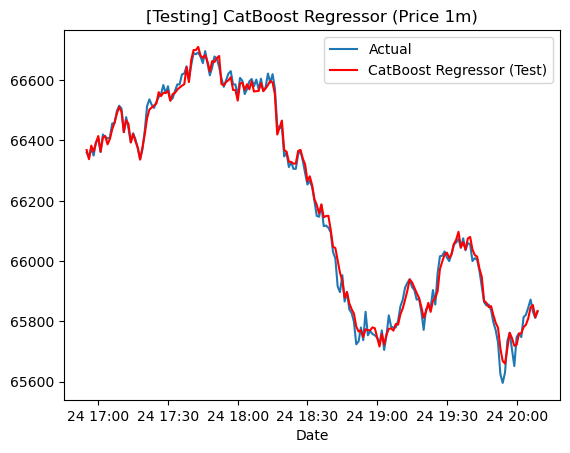

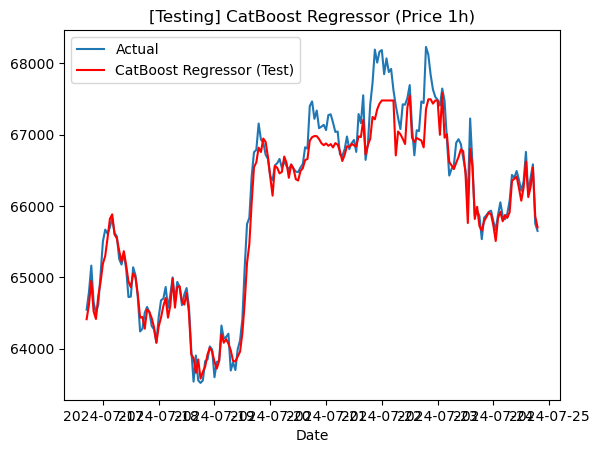

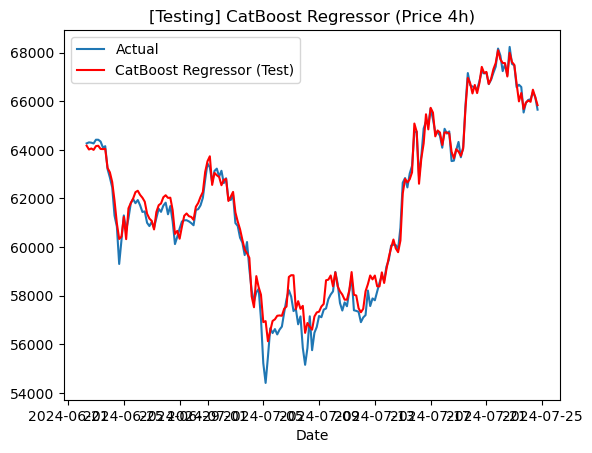

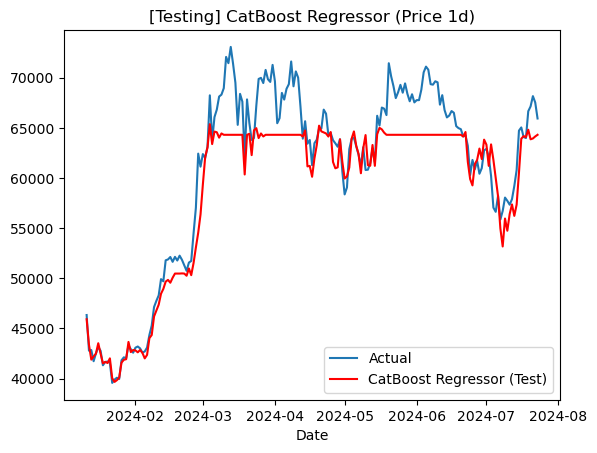

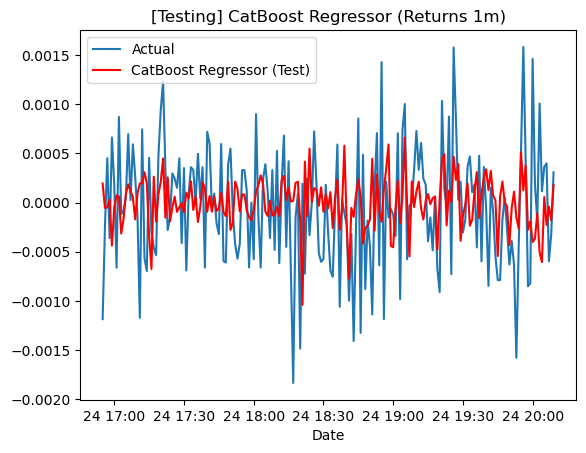

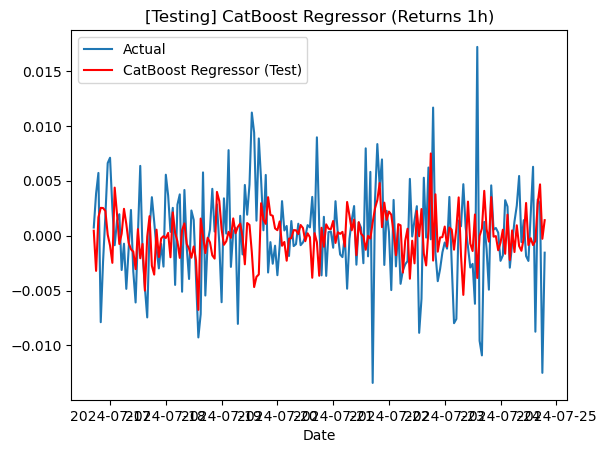

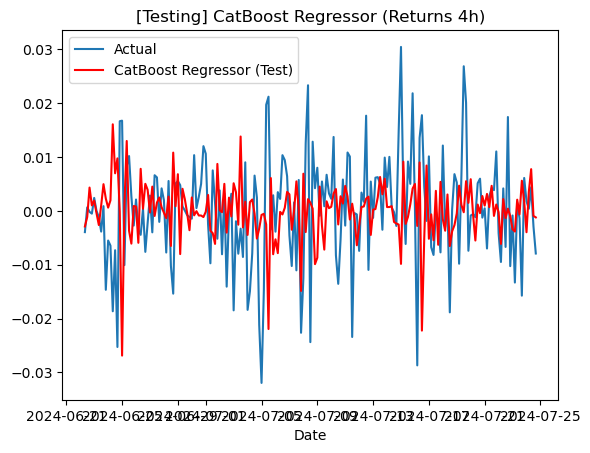

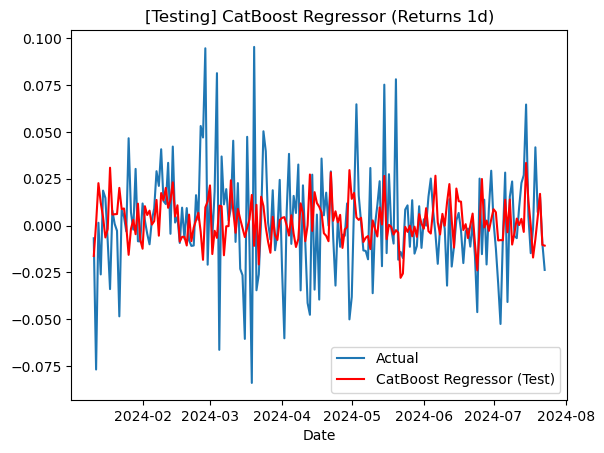

In [259]:
plot_forecast_result(cb_preds_train_1m_price, cb_preds_test_1m_price, df_1m['close'], 'CatBoost Regressor (Price 1m)', 'test')
plot_forecast_result(cb_preds_train_1h_price, cb_preds_test_1h_price, df_1h['close'], 'CatBoost Regressor (Price 1h)', 'test')
plot_forecast_result(cb_preds_train_4h_price, cb_preds_test_4h_price, df_4h['close'], 'CatBoost Regressor (Price 4h)', 'test')
plot_forecast_result(cb_preds_train_1d_price, cb_preds_test_1d_price, df_1d['close'], 'CatBoost Regressor (Price 1d)', 'test')

plot_forecast_result(cb_preds_train_1m_returns, cb_preds_test_1m_returns, df_1m['returns'], 'CatBoost Regressor (Returns 1m)', 'test')
plot_forecast_result(cb_preds_train_1h_returns, cb_preds_test_1h_returns, df_1h['returns'], 'CatBoost Regressor (Returns 1h)', 'test')
plot_forecast_result(cb_preds_train_4h_returns, cb_preds_test_4h_returns, df_4h['returns'], 'CatBoost Regressor (Returns 4h)', 'test')
plot_forecast_result(cb_preds_train_1d_returns, cb_preds_test_1d_returns, df_1d['returns'], 'CatBoost Regressor (Returns 1d)', 'test')

## LSTM

In [278]:
import keras

In [279]:
class lstmModel():
    def __init__(self, window_size):
        self.window_size = window_size

    def build_model(self):
        lstm_model = keras.Sequential()
        lstm_model.add(keras.layers.InputLayer((self.window_size, 1)))
        lstm_model.add(keras.layers.LSTM(128, return_sequences=True))
        lstm_model.add(keras.layers.Dropout(0.2))
        lstm_model.add(keras.layers.LSTM(64))
        lstm_model.add(keras.layers.Dropout(0.2))
        lstm_model.add(keras.layers.Dense(32, activation='relu'))
        lstm_model.add(keras.layers.Dense(1, activation='linear'))

        lstm_model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.0001))

        return lstm_model

In [280]:
lstm_model_1m_price = lstmModel(window_size).build_model()
lstm_model_1h_price = lstmModel(window_size).build_model()
lstm_model_4h_price = lstmModel(window_size).build_model()
lstm_model_1d_price = lstmModel(window_size).build_model()

lstm_model_1m_returns = lstmModel(window_size).build_model()
lstm_model_1h_returns = lstmModel(window_size).build_model()
lstm_model_4h_returns = lstmModel(window_size).build_model()
lstm_model_1d_returns = lstmModel(window_size).build_model()

In [281]:
lstm_model_1m_price.fit(train_1m_price, train_label_1m_price, epochs=lstm_epochs)
lstm_model_1h_price.fit(train_1h_price, train_label_1h_price, epochs=lstm_epochs)
lstm_model_4h_price.fit(train_4h_price, train_label_4h_price, epochs=lstm_epochs)
lstm_model_1d_price.fit(train_1d_price, train_label_1d_price, epochs=lstm_epochs)

lstm_model_1m_returns.fit(train_1m_returns, train_label_1m_returns, epochs=lstm_epochs)
lstm_model_1h_returns.fit(train_1h_returns, train_label_1h_returns, epochs=lstm_epochs)
lstm_model_4h_returns.fit(train_4h_returns, train_label_4h_returns, epochs=lstm_epochs)
lstm_model_1d_returns.fit(train_1d_returns, train_label_1d_returns, epochs=lstm_epochs)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.9226
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6944
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5445
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3357
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1252
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0488
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0507
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0501
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0491
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0476
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0535
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0503
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0512
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0467
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0465
Epoch 16/50
25/2

In [282]:
lstm_preds_train_1m_price = scaler_1m_price.inverse_transform(lstm_model_1m_price.predict(train_1m_price))
lstm_preds_train_1h_price = scaler_1h_price.inverse_transform(lstm_model_1h_price.predict(train_1h_price))
lstm_preds_train_4h_price = scaler_4h_price.inverse_transform(lstm_model_4h_price.predict(train_4h_price))
lstm_preds_train_1d_price = scaler_1d_price.inverse_transform(lstm_model_1d_price.predict(train_1d_price))

lstm_preds_test_1m_price = scaler_1m_price.inverse_transform(lstm_model_1m_price.predict(test_1m_price))
lstm_preds_test_1h_price = scaler_1h_price.inverse_transform(lstm_model_1h_price.predict(test_1h_price))
lstm_preds_test_4h_price = scaler_4h_price.inverse_transform(lstm_model_4h_price.predict(test_4h_price))
lstm_preds_test_1d_price = scaler_1d_price.inverse_transform(lstm_model_1d_price.predict(test_1d_price))

lstm_preds_train_1m_returns = scaler_1m_returns.inverse_transform(lstm_model_1m_returns.predict(train_1m_returns))
lstm_preds_train_1h_returns = scaler_1h_returns.inverse_transform(lstm_model_1h_returns.predict(train_1h_returns))
lstm_preds_train_4h_returns = scaler_4h_returns.inverse_transform(lstm_model_4h_returns.predict(train_4h_returns))
lstm_preds_train_1d_returns = scaler_1d_returns.inverse_transform(lstm_model_1d_returns.predict(train_1d_returns))

lstm_preds_test_1m_returns = scaler_1m_returns.inverse_transform(lstm_model_1m_returns.predict(test_1m_returns))
lstm_preds_test_1h_returns = scaler_1h_returns.inverse_transform(lstm_model_1h_returns.predict(test_1h_returns))
lstm_preds_test_4h_returns = scaler_4h_returns.inverse_transform(lstm_model_4h_returns.predict(test_4h_returns))
lstm_preds_test_1d_returns = scaler_1d_returns.inverse_transform(lstm_model_1d_returns.predict(test_1d_returns))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [283]:
print('***LSTM Training Evaluation (Price)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(actual_train_label_1m_price, lstm_preds_train_1m_price):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1m_price, lstm_preds_train_1m_price):.6f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(actual_train_label_1h_price, lstm_preds_train_1h_price):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1h_price, lstm_preds_train_1h_price):.6f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(actual_train_label_4h_price, lstm_preds_train_4h_price):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_4h_price, lstm_preds_train_4h_price):.6f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(actual_train_label_1d_price, lstm_preds_train_1d_price):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1d_price, lstm_preds_train_1d_price):.6f}')

***LSTM Training Evaluation (Price)***
---1 Minute---
R²: 0.962478
MSE: 3494.636557
---1 Hour---
R²: 0.977668
MSE: 250220.117098
---4 Hours---
R²: 0.962157
MSE: 1360491.761100
---1 Days---
R²: 0.978460
MSE: 2449995.063350


In [284]:
print('***LSTM Testing Evaluation (Price)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(actual_test_label_1m_price, lstm_preds_test_1m_price):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1m_price, lstm_preds_test_1m_price):.6f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(actual_test_label_1h_price, lstm_preds_test_1h_price):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1h_price, lstm_preds_test_1h_price):.6f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(actual_test_label_4h_price, lstm_preds_test_4h_price):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_4h_price, lstm_preds_test_4h_price):.6f}')
print('---1 Day---')
print(f'R\u00b2: {r2_score(actual_test_label_1d_price, lstm_preds_test_1d_price):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1d_price, lstm_preds_test_1d_price):.6f}')

***LSTM Testing Evaluation (Price)***
---1 Minute---
R²: 0.958712
MSE: 4732.720373
---1 Hour---
R²: 0.841070
MSE: 252112.035677
---4 Hours---
R²: 0.906825
MSE: 1127700.908946
---1 Day---
R²: 0.880323
MSE: 10272768.289212


In [285]:
print('***LSTM Training Evaluation (Returns)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(actual_train_label_1m_returns, lstm_preds_train_1m_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1m_returns, lstm_preds_train_1m_returns):.6f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(actual_train_label_1h_returns, lstm_preds_train_1h_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1h_returns, lstm_preds_train_1h_returns):.6f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(actual_train_label_4h_returns, lstm_preds_train_4h_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_4h_returns, lstm_preds_train_4h_returns):.6f}')
print('---1 Days---')
print(f'R\u00b2: {r2_score(actual_train_label_1d_returns, lstm_preds_train_1d_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_train_label_1d_returns, lstm_preds_train_1d_returns):.6f}')

***LSTM Training Evaluation (Returns)***
---1 Minute---
R²: -0.055766
MSE: 0.000000
---1 Hour---
R²: -0.040240
MSE: 0.000026
---4 Hours---
R²: -0.097762
MSE: 0.000145
---1 Days---
R²: -0.050938
MSE: 0.000890


In [286]:
print('***LSTM Testing Evaluation (Returns)***')
print('---1 Minute---')
print(f'R\u00b2: {r2_score(actual_test_label_1m_returns, lstm_preds_test_1m_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1m_returns, lstm_preds_test_1m_returns):.6f}')
print('---1 Hour---')
print(f'R\u00b2: {r2_score(actual_test_label_1h_returns, lstm_preds_test_1h_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1h_returns, lstm_preds_test_1h_returns):.6f}')
print('---4 Hours---')
print(f'R\u00b2: {r2_score(actual_test_label_4h_returns, lstm_preds_test_4h_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_4h_returns, lstm_preds_test_4h_returns):.6f}')
print('---1 Day---')
print(f'R\u00b2: {r2_score(actual_test_label_1d_returns, lstm_preds_test_1d_returns):.6f}')
print(f'MSE: {mean_squared_error(actual_test_label_1d_returns, lstm_preds_test_1d_returns):.6f}')

***LSTM Testing Evaluation (Returns)***
---1 Minute---
R²: -0.005925
MSE: 0.000000
---1 Hour---
R²: -0.068701
MSE: 0.000021
---4 Hours---
R²: -0.051290
MSE: 0.000104
---1 Day---
R²: -0.045465
MSE: 0.000825


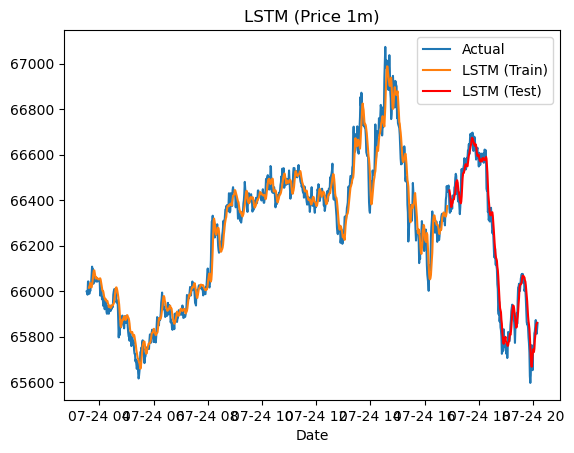

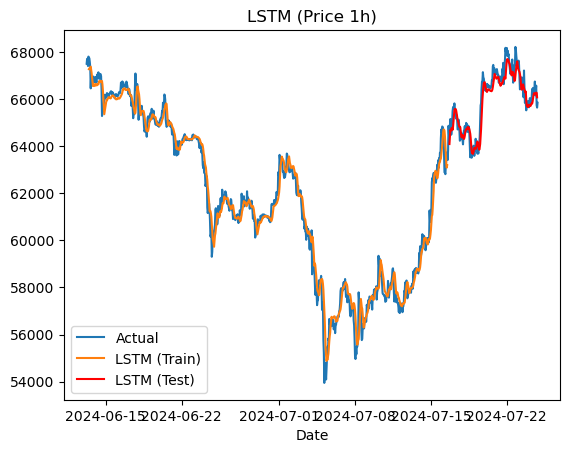

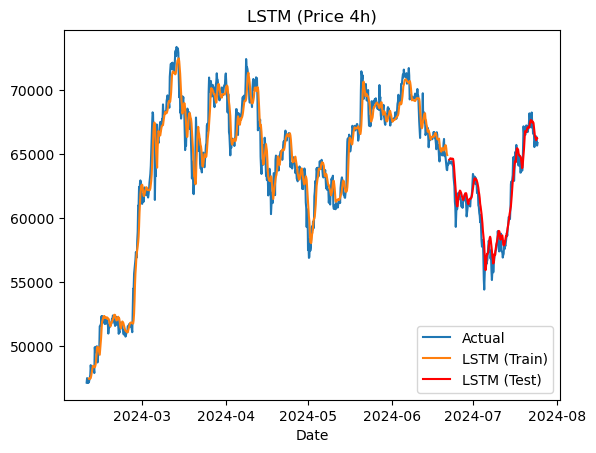

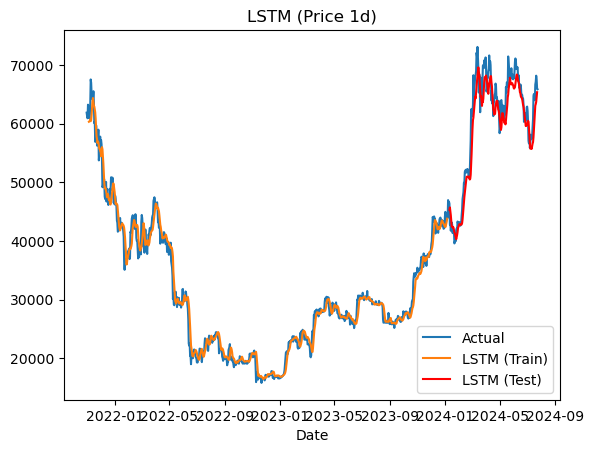

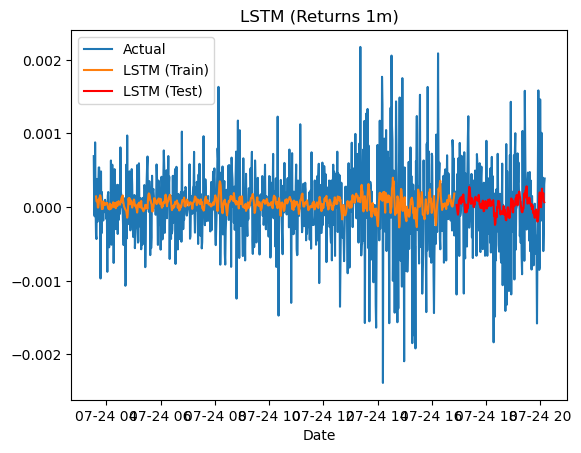

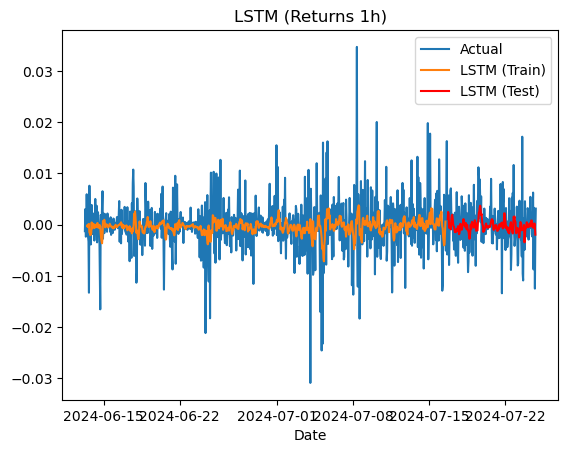

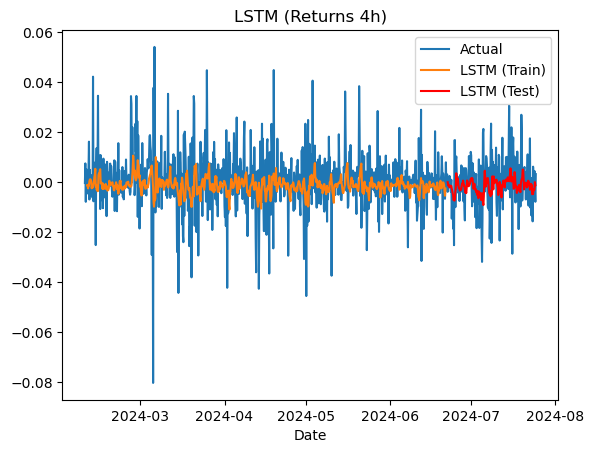

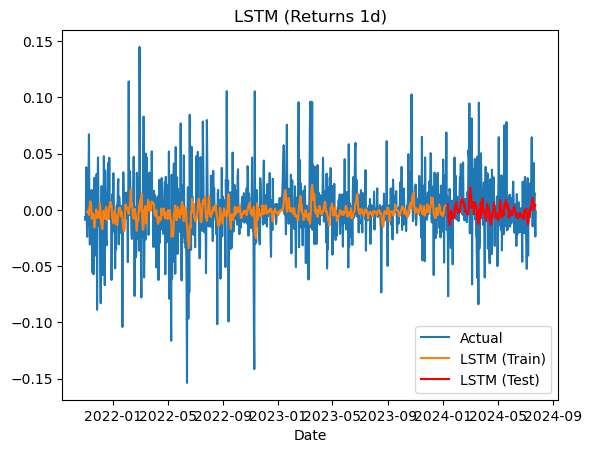

In [287]:
plot_forecast_result(lstm_preds_train_1m_price, lstm_preds_test_1m_price, df_1m['close'], 'LSTM (Price 1m)')
plot_forecast_result(lstm_preds_train_1h_price, lstm_preds_test_1h_price, df_1h['close'], 'LSTM (Price 1h)')
plot_forecast_result(lstm_preds_train_4h_price, lstm_preds_test_4h_price, df_4h['close'], 'LSTM (Price 4h)')
plot_forecast_result(lstm_preds_train_1d_price, lstm_preds_test_1d_price, df_1d['close'], 'LSTM (Price 1d)')

plot_forecast_result(lstm_preds_train_1m_returns, lstm_preds_test_1m_returns, df_1m['returns'], 'LSTM (Returns 1m)')
plot_forecast_result(lstm_preds_train_1h_returns, lstm_preds_test_1h_returns, df_1h['returns'], 'LSTM (Returns 1h)')
plot_forecast_result(lstm_preds_train_4h_returns, lstm_preds_test_4h_returns, df_4h['returns'], 'LSTM (Returns 4h)')
plot_forecast_result(lstm_preds_train_1d_returns, lstm_preds_test_1d_returns, df_1d['returns'], 'LSTM (Returns 1d)')

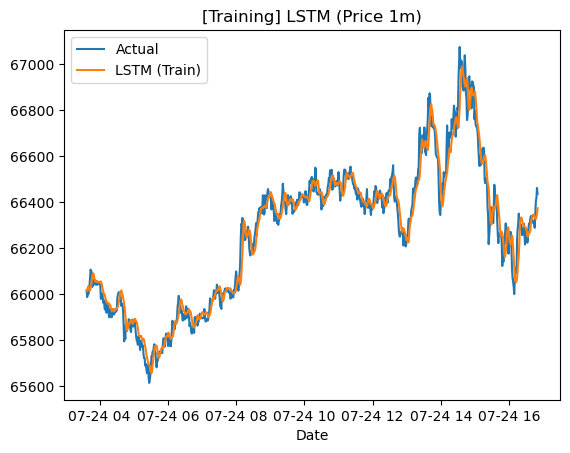

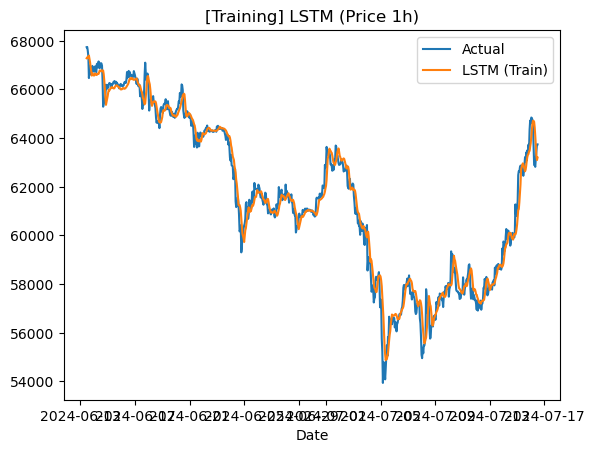

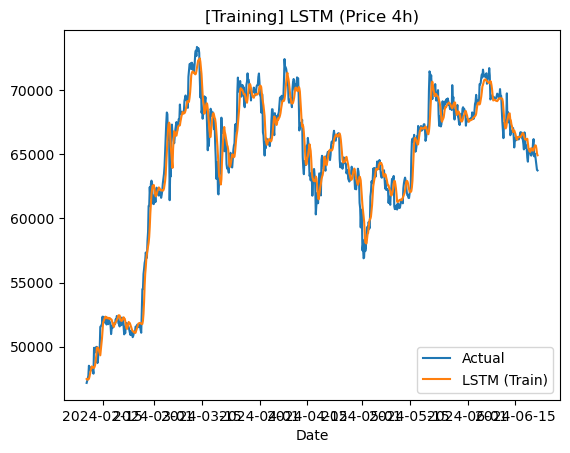

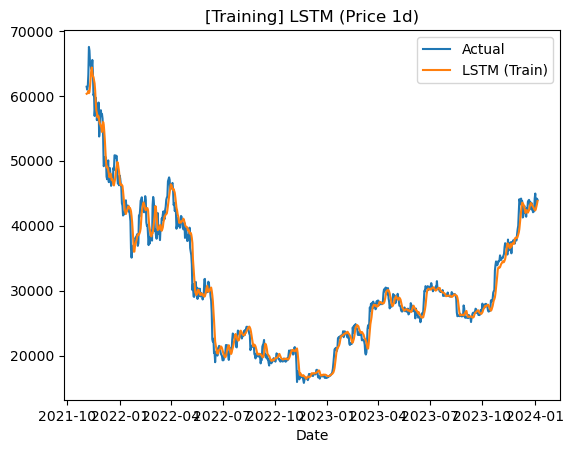

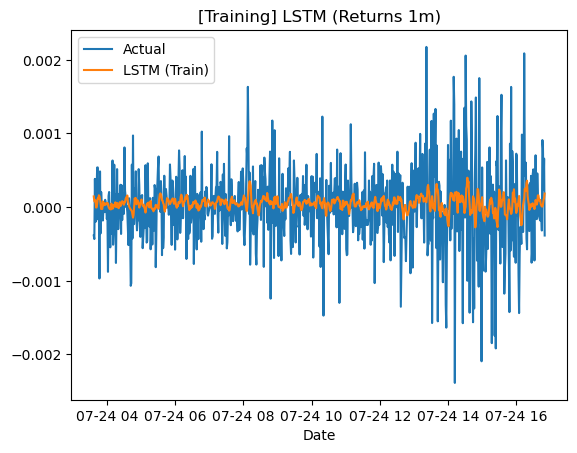

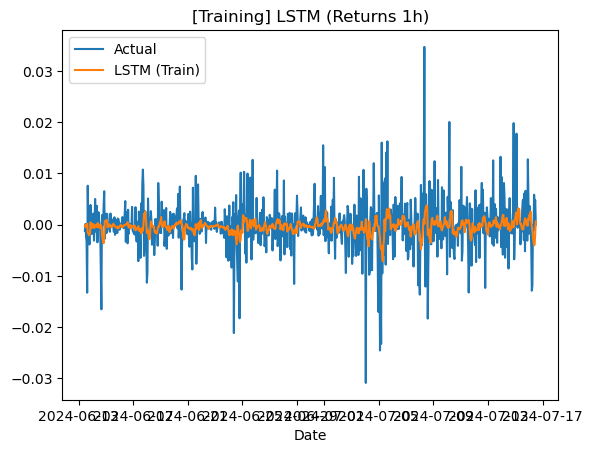

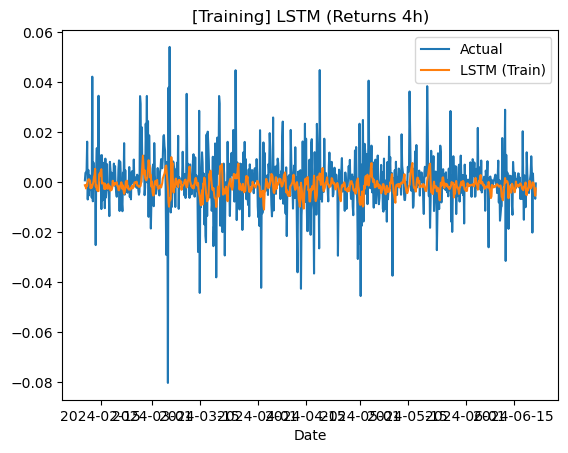

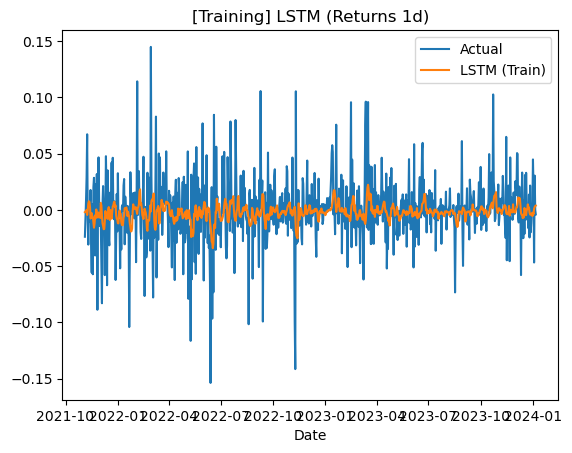

In [288]:
plot_forecast_result(lstm_preds_train_1m_price, lstm_preds_test_1m_price, df_1m['close'], 'LSTM (Price 1m)', 'train')
plot_forecast_result(lstm_preds_train_1h_price, lstm_preds_test_1h_price, df_1h['close'], 'LSTM (Price 1h)', 'train')
plot_forecast_result(lstm_preds_train_4h_price, lstm_preds_test_4h_price, df_4h['close'], 'LSTM (Price 4h)', 'train')
plot_forecast_result(lstm_preds_train_1d_price, lstm_preds_test_1d_price, df_1d['close'], 'LSTM (Price 1d)', 'train')

plot_forecast_result(lstm_preds_train_1m_returns, lstm_preds_test_1m_returns, df_1m['returns'], 'LSTM (Returns 1m)', 'train')
plot_forecast_result(lstm_preds_train_1h_returns, lstm_preds_test_1h_returns, df_1h['returns'], 'LSTM (Returns 1h)', 'train')
plot_forecast_result(lstm_preds_train_4h_returns, lstm_preds_test_4h_returns, df_4h['returns'], 'LSTM (Returns 4h)', 'train')
plot_forecast_result(lstm_preds_train_1d_returns, lstm_preds_test_1d_returns, df_1d['returns'], 'LSTM (Returns 1d)', 'train')

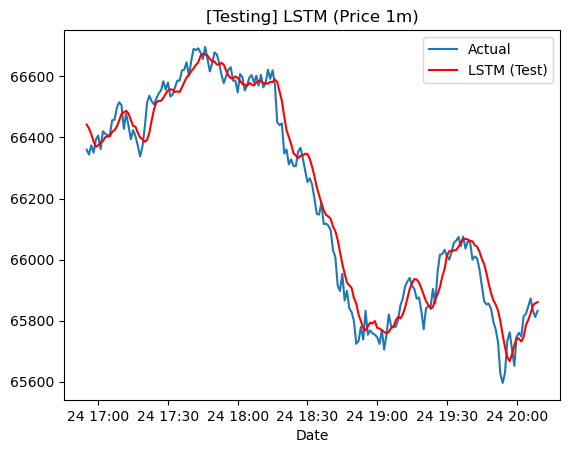

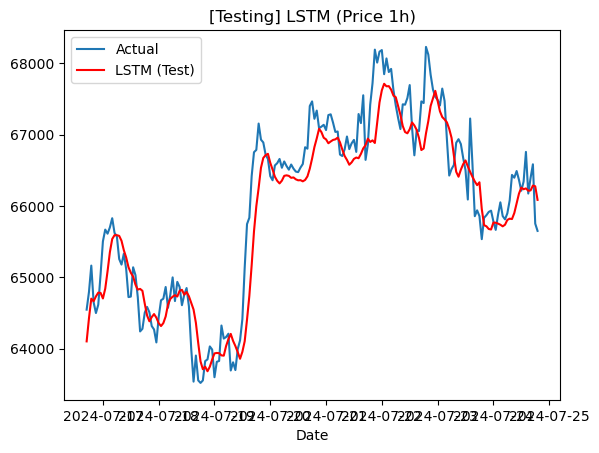

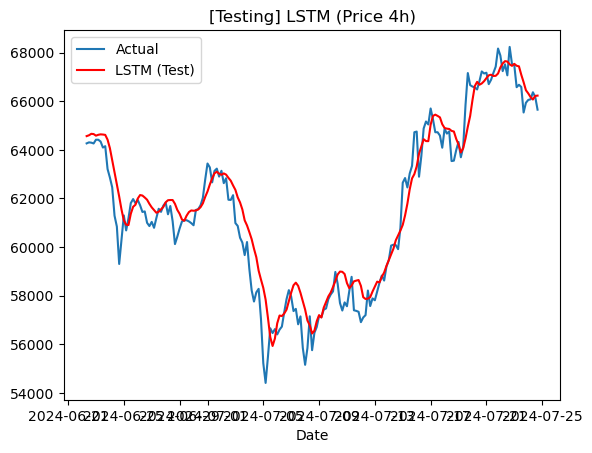

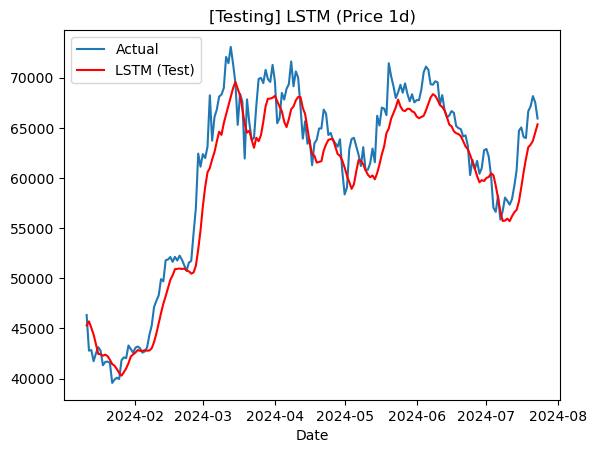

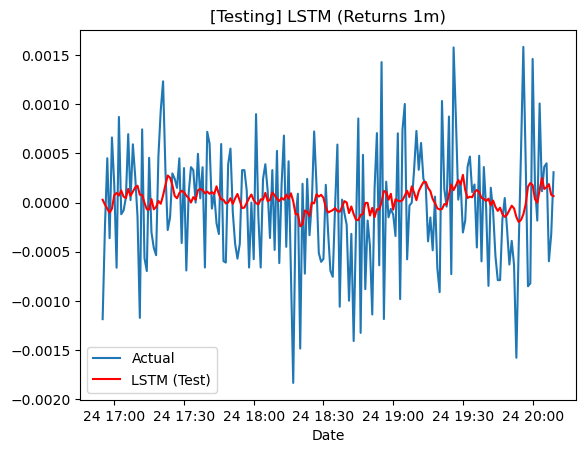

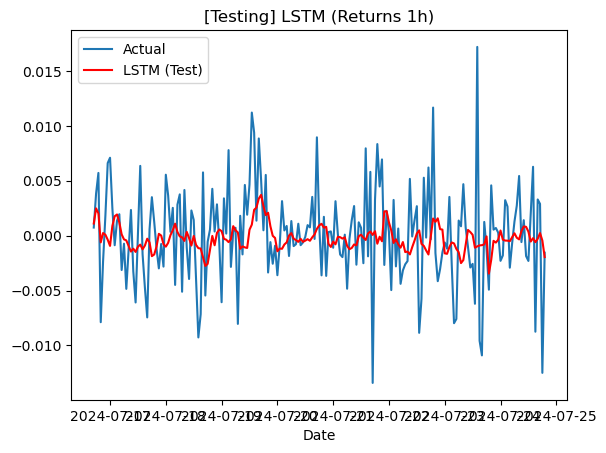

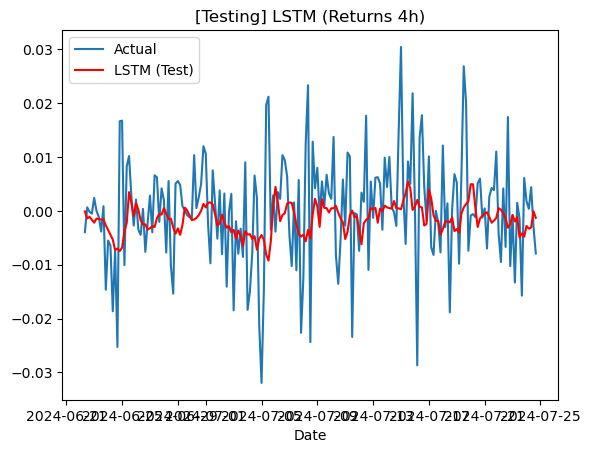

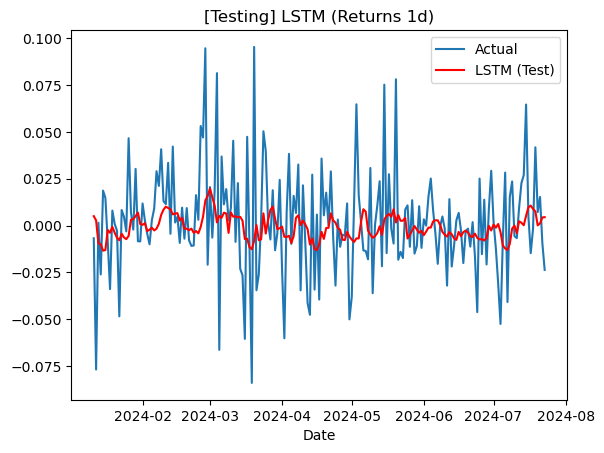

In [289]:
plot_forecast_result(lstm_preds_train_1m_price, lstm_preds_test_1m_price, df_1m['close'], 'LSTM (Price 1m)', 'test')
plot_forecast_result(lstm_preds_train_1h_price, lstm_preds_test_1h_price, df_1h['close'], 'LSTM (Price 1h)', 'test')
plot_forecast_result(lstm_preds_train_4h_price, lstm_preds_test_4h_price, df_4h['close'], 'LSTM (Price 4h)', 'test')
plot_forecast_result(lstm_preds_train_1d_price, lstm_preds_test_1d_price, df_1d['close'], 'LSTM (Price 1d)', 'test')

plot_forecast_result(lstm_preds_train_1m_returns, lstm_preds_test_1m_returns, df_1m['returns'], 'LSTM (Returns 1m)', 'test')
plot_forecast_result(lstm_preds_train_1h_returns, lstm_preds_test_1h_returns, df_1h['returns'], 'LSTM (Returns 1h)', 'test')
plot_forecast_result(lstm_preds_train_4h_returns, lstm_preds_test_4h_returns, df_4h['returns'], 'LSTM (Returns 4h)', 'test')
plot_forecast_result(lstm_preds_train_1d_returns, lstm_preds_test_1d_returns, df_1d['returns'], 'LSTM (Returns 1d)', 'test')

## Q-Learning

In [290]:
from ta.momentum import RSIIndicator
from ta.trend import CCIIndicator, MACD
from ta.volatility import BollingerBands

In [291]:
class QlearningModel:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_min=0.1, decay_rate=0.9):
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Initial exploration rate
        self.epsilon_min = epsilon_min  # Minimum exploration rate
        self.decay_rate = decay_rate  # Decay rate for exploration
        self.q_table = {}  # Q-table
        self.previous_state = None
        self.previous_action = None
        self.cumulative_reward = 0
    
    def get_state(self, data):
        rsi = RSIIndicator(data['close']).rsi().iloc[-1]
        cci = CCIIndicator(data['high'], data['low'], data['close']).cci().iloc[-1]
        macd = MACD(data['close'])
        macd_line = macd.macd().iloc[-1]
        signal_line = macd.macd_signal().iloc[-1]
        bollinger = BollingerBands(data['close'])
        upper_band = bollinger.bollinger_hband().iloc[-1]
        lower_band = bollinger.bollinger_lband().iloc[-1]
        close_price = data['close'].iloc[-1]

        rsi_state = 'overbought' if rsi > 70 else 'oversold' if rsi < 30 else 'neutral'
        cci_state = 'overbought' if cci > 100 else 'oversold' if cci < -100 else 'neutral'
        macd_state = 'strong bullish' if macd_line > signal_line and macd_line > 0 else \
                     'weak bullish' if macd_line > signal_line and macd_line < 0 else \
                     'strong bearish' if macd_line < signal_line and macd_line < 0 else \
                     'weak bearish' if macd_line < signal_line and macd_line > 0 else 'neutral'
        bollinger_state = 'above upper band' if close_price > upper_band else \
                          'below lower band' if close_price < lower_band else 'within bands'

        state = (rsi_state, cci_state, macd_state, bollinger_state)
        return state

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(['buy', 'sell', 'hold'])
        else:
            q_values = [self.get_q_value(state, action) for action in ['buy', 'sell', 'hold']]
            max_q = max(q_values)
            action = np.random.choice([action for action, q in zip(['buy', 'sell', 'hold'], q_values) if q == max_q])
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.decay_rate)
        
        return action

    def update_q_table(self, previous_state, previous_action, reward, current_state):
        prev_q = self.get_q_value(previous_state, previous_action)
        max_future_q = max([self.get_q_value(current_state, action) for action in ['buy', 'sell', 'hold']])
        new_q = prev_q + self.alpha * (reward + self.gamma * max_future_q - prev_q)
        self.q_table[(previous_state, previous_action)] = new_q

    def calculate_reward(self, data, action):
        price_diff = data['close'].iloc[-1] - data['close'].iloc[-2]
        if action == 'buy':
            reward = price_diff
        elif action == 'sell':
            reward = -price_diff
        else:
            reward = 0
        self.cumulative_reward += reward
        return reward
    
    def trade(self, data):
        if len(data) < 2:
            return
        current_state = self.get_state(data)
        action = self.choose_action(current_state)

        if self.previous_state is not None and self.previous_action is not None:
            reward = self.calculate_reward(data, self.previous_action)
            self.update_q_table(self.previous_state, self.previous_action, reward, current_state)

        self.previous_state = current_state
        self.previous_action = action


In [292]:
ql_model_1m = QlearningModel()
ql_model_1h = QlearningModel()
ql_model_4h = QlearningModel()
ql_model_1d = QlearningModel()

In [293]:
def evaluate_ql_model(ql_model, df):
    cumulative_rewards = []
    for i in range(10):
        for timestamp, row in df.iterrows():
            ql_model.trade(df.loc[:timestamp])
        cumulative_rewards.append(ql_model.cumulative_reward)
    return np.array(cumulative_rewards)

In [294]:
ql_model_1m_return = evaluate_ql_model(ql_model_1m, df_1m)
ql_model_1h_return = evaluate_ql_model(ql_model_1h, df_1h)
ql_model_4h_return = evaluate_ql_model(ql_model_4h, df_4h)
ql_model_1d_return = evaluate_ql_model(ql_model_1d, df_1d)

In [313]:
print('***Q-Learning Evaluation***')
print(f'Average Return of Q-Learning Model 1m: {ql_model_1m_return.mean():.4f}')
print(f'Average Return of Q-Learning Model 1h: {ql_model_1h_return.mean():.4f}')
print(f'Average Return of Q-Learning Model 4h: {ql_model_4h_return.mean():.4f}')
print(f'Average Return of Q-Learning Model 1d: {ql_model_1d_return.mean():.4f}')

***Q-Learning Evaluation***
Average Return of Q-Learning Model 1m: -2224.7070
Average Return of Q-Learning Model 1h: 13708.5850
Average Return of Q-Learning Model 4h: 76867.2040
Average Return of Q-Learning Model 1d: 21452.2170


In [314]:
for i in range(10):
    print(f'Return of Q-Learning Model 1m at iteration {i+1}: {ql_model_1m_return[i]:.4f}')

Return of Q-Learning Model 1m at iteration 1: -796.2300
Return of Q-Learning Model 1m at iteration 2: -1148.3300
Return of Q-Learning Model 1m at iteration 3: -1309.2700
Return of Q-Learning Model 1m at iteration 4: -2284.3000
Return of Q-Learning Model 1m at iteration 5: -2400.0700
Return of Q-Learning Model 1m at iteration 6: -2425.7900
Return of Q-Learning Model 1m at iteration 7: -2703.8000
Return of Q-Learning Model 1m at iteration 8: -3123.7600
Return of Q-Learning Model 1m at iteration 9: -2630.9300
Return of Q-Learning Model 1m at iteration 10: -3424.5900


In [315]:
for i in range(10):
    print(f'Return of Q-Learning Model 1h at iteration {i+1}: {ql_model_1h_return[i]:.4f}')

Return of Q-Learning Model 1h at iteration 1: -1375.7400
Return of Q-Learning Model 1h at iteration 2: 5756.7500
Return of Q-Learning Model 1h at iteration 3: 7756.6500
Return of Q-Learning Model 1h at iteration 4: 12385.0000
Return of Q-Learning Model 1h at iteration 5: 15557.5200
Return of Q-Learning Model 1h at iteration 6: 11994.6500
Return of Q-Learning Model 1h at iteration 7: 16243.6100
Return of Q-Learning Model 1h at iteration 8: 17360.4900
Return of Q-Learning Model 1h at iteration 9: 23867.8000
Return of Q-Learning Model 1h at iteration 10: 27539.1200


In [316]:
for i in range(10):
    print(f'Return of Q-Learning Model 4h at iteration {i+1}: {ql_model_4h_return[i]:.4f}')

Return of Q-Learning Model 4h at iteration 1: -14148.4100
Return of Q-Learning Model 4h at iteration 2: 2978.8900
Return of Q-Learning Model 4h at iteration 3: 3865.4300
Return of Q-Learning Model 4h at iteration 4: 28767.8500
Return of Q-Learning Model 4h at iteration 5: 52055.2500
Return of Q-Learning Model 4h at iteration 6: 79731.8700
Return of Q-Learning Model 4h at iteration 7: 111769.3400
Return of Q-Learning Model 4h at iteration 8: 136215.4800
Return of Q-Learning Model 4h at iteration 9: 167508.0800
Return of Q-Learning Model 4h at iteration 10: 199928.2600


In [317]:
for i in range(10):
    print(f'Return of Q-Learning Model 1d at iteration {i+1}: {ql_model_1d_return[i]:.6f}')

Return of Q-Learning Model 1d at iteration 1: -21469.140000
Return of Q-Learning Model 1d at iteration 2: -15011.260000
Return of Q-Learning Model 1d at iteration 3: -2956.880000
Return of Q-Learning Model 1d at iteration 4: 4810.730000
Return of Q-Learning Model 1d at iteration 5: 2053.230000
Return of Q-Learning Model 1d at iteration 6: 5437.080000
Return of Q-Learning Model 1d at iteration 7: 17759.780000
Return of Q-Learning Model 1d at iteration 8: 41489.910000
Return of Q-Learning Model 1d at iteration 9: 70968.480000
Return of Q-Learning Model 1d at iteration 10: 111440.240000
